Описание данных
wellName Название скважины

datasetName Название набора данных

MD Измеренная глубина

BK Боковой каротаж (сопротивление)

Facies Фация (свойство)

GR Гамма-каротаж

LIT Литология

NKTB Нейтронный каротаж

SP Метод потенциалов собственной поляризации

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале

Нужно определять фации в коллеторах (LIT = 4)

1 – глина

2 – алевролит

5- плотная порода

6 - уголь

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале, но не выше 2000 м (MD>2000)

Самые основные конечно – GR и SP, их форму геологи учитывают для определения условий осадконакопления, можно будет попробовать оценить форму кривых, а не значения параметра) Единственный нюанс – пока в таблице всего 19 скважин, но фации в них выделены наиболее уверенно. Ну и судя по всему, информация с MD < 2000 не принципиальна

SP (каротаж естественной поляризации)
GR (гамма каротаж)
DT (акустический каротаж)
Density (плотностной каротаж)

In [3]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
import lasio
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from IPython.display import display, clear_output
%matplotlib inline

In [3]:
# из данных удалены единицы измерения
base_statistic_df = pd.read_csv('DATATRAIN18.csv', sep=';')
base_statistic_df.describe()


MD             BK         Facies             GR  \
count  128983.000000  125095.000000  128983.000000  128983.000000   
mean     1761.404695   -4316.786514   -9738.083057   -2282.044775   
std       720.630001    4964.688683    1594.423364    4205.785955   
min         0.000000   -9999.000000   -9999.000000   -9999.000000   
25%      1277.600000   -9999.000000   -9999.000000       3.867000   
50%      1926.600000       4.080000   -9999.000000       8.133000   
75%      2328.200000       7.550000   -9999.000000      10.740000   
max      3093.000000   22739.520000      12.000000     142.370000   

                 LIT           NKTB             SP  
count  128983.000000  128983.000000  128287.000000  
mean    -8668.915252   -2282.085637   -2219.377482  
std      3396.061297    4199.757195    4255.831173  
min     -9999.000000   -9999.000000   -9999.000000  
25%     -9999.000000       2.071199      44.940080  
50%     -9999.000000       3.131862      95.280000  
75%     -9999.000000       3.868000     117.877750  
max         6.000000      22.582870     578.255500

фильтруем чтобы MD(глубина) > 2000 LIT(тип) = 4

In [25]:
def get_clean_df(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    feature = feature[feature["Facies"] >= -111]
    #feature = feature[feature["MD"] >= 2520]
    #feature = feature[feature["MD"] <= 2625]
    #feature = feature[feature["LIT"] == 4]
    #feature = feature[feature["Facies"] != -9999]
    return feature

def change_null(x):
    if x == -9999: 
        return -1 
    return x

def get_well_dfs(all_well_df):
    wall_names = all_well_df['wellName'].unique()
    print(wall_names)
    wells = []
    for name in wall_names:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

def print_all_features_well(well_name):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(filter_base_df[filter_base_df['wellName'] == well_name])


filter_base_df = get_clean_df(base_statistic_df)
filter_base_df["Facies"] =  filter_base_df["Facies"].apply(lambda x: change_null(x))
filter_base_df.describe()


wellName      MD      BK  Facies      GR  LIT      NKTB        SP
124621  spk432R  2594.8   9.229       5   7.792    5  6.972652  183.1473
124622  spk432R  2595.0  32.915       5   9.991    5  7.003152  181.5819
124623  spk432R  2595.2  17.483       5  13.590    1  4.750431  183.2746
124624  spk432R  2595.4  11.487       5  13.685    1  3.296657  187.6532
124625  spk432R  2595.6  15.096       5  11.865    1  2.500102  191.5478
124626  spk432R  2595.8  26.751       5  10.536    2  2.264484  192.2244
124627  spk432R  2596.0  28.371       5   9.843    2  2.725554  193.0560
124628  spk432R  2596.2  14.168       5  11.552    2  3.751747  192.7926
124629  spk432R  2596.4   8.176       5  11.990    2  5.125386  192.5872
124630  spk432R  2596.6   5.937       5   9.802    2  5.258145  190.7808
124631  spk432R  2596.8   3.414       5   9.571    2  5.870512  187.6354
124632  spk432R  2597.0   7.315       5  10.538    2  5.762869  185.2560
124633  spk432R  2597.2   7.452       5  11.350    2  5.268909  188.5557
124634  spk432R  2597.4   7.507       5  11.934    2  5.344259  191.4063
124635  spk432R  2597.6   7.885       5  10.694    2  5.197147  193.0389
124636  spk432R  2597.8   9.076       5   8.959    2  5.740145  193.3415
124637  spk432R  2598.0  28.127       5   8.690    5  6.370452  194.6651
124638  spk432R  2598.2  15.905       5  10.881    5  5.881276  195.2567
124639  spk432R  2598.4   9.094       5  13.074    5  5.182197  196.2603
124640  spk432R  2598.6   8.469       5  13.188    1  4.980068  196.4310
124641  spk432R  2598.8   8.041       5  11.784    1  5.115818  195.8065
124642  spk432R  2599.0   8.120       5   9.009    1  6.013437  192.6292
124643  spk432R  2599.2  13.106       5   6.092    5  7.083286  190.3138
124644  spk432R  2599.4  65.939       5   5.945    5  8.046687  189.1134
124645  spk432R  2599.6  41.496       5   9.196    5  6.818963  189.2490
124646  spk432R  2599.8   9.038       5  11.724    5  4.611691  189.2646
124647  spk432R  2600.0   6.744       5  11.516    1  4.076468  189.8222
124648  spk432R  2600.2   6.033       5  11.765    1  4.744451  188.2768
124649  spk432R  2600.4   6.075       5  12.220    1  4.768969  188.2655
124650  spk432R  2600.6   6.419       5  11.687    1  4.807242  186.6671
124651  spk432R  2600.8   6.878       5  11.636    1  4.538733  187.5177
124652  spk432R  2601.0   6.919       5  12.488    1  4.466972  190.0553
124653  spk432R  2601.2   6.923       5  13.312    1  4.039392  192.2319
124654  spk432R  2601.4   7.072       5  13.308    1  3.909622  193.8555
124655  spk432R  2601.6   7.489       5  13.249    1  3.992148  194.8351
124656  spk432R  2601.8   7.375       5  13.531    1  3.916201  195.4277
124657  spk432R  2602.0   6.949       5  13.146    1  3.904240  195.6533
124658  spk432R  2602.2   6.661       5  13.359    1  3.944905  195.5600
124659  spk432R  2602.4   6.943       5  13.542    1  3.724238  196.1736
124660  spk432R  2602.6   7.093       5  14.581    1  3.479650  197.4832
124661  spk432R  2602.8   7.199       5  14.892    1  3.954473  197.6418
124662  spk432R  2603.0   7.768       5  15.207    1  3.912014  198.5364
124663  spk432R  2603.2   7.767       5  15.542    1  3.499384  198.7310
124664  spk432R  2603.4   7.830       5  15.897    1  3.610615  199.9746
124665  spk432R  2603.6   7.353       5  16.346    1  3.778657  200.3592
124666  spk432R  2603.8   7.236       5  16.015    1  3.762511  200.8178
124667  spk432R  2604.0   7.329       5  15.745    1  3.769687  201.2035
124668  spk432R  2604.2   7.546       5  14.944    1  3.614801  200.1921
124669  spk432R  2604.4   7.785       5  15.112    1  3.437191  199.2557
124670  spk432R  2604.6   8.014       5  14.923    1  4.020255  199.4483
124671  spk432R  2604.8   7.806       5  14.278    1  3.862977  198.3789
124672  spk432R  2605.0   6.281       5  13.939    1  3.748756  197.5285
124673  spk432R  2605.2   6.383       5  14.346    1  4.388632  196.0161
124674  spk432R  2605.4   5.742       5  15.682    1  4.534548  1

['spk1521' 'spk1527' 'spk1769' 'spk400' 'spk403' 'spk405R' 'spk406R'
 'spk409R' 'spk420R' 'spk424R' 'spk426R' 'spk427R' 'spk428R' 'spk429L'
 'spk432R' 'spk967']
['Скважина - spk1521']
Статистика по всем значениям


MD          BK      Facies          GR    LIT        NKTB  \
count   118.000000  118.000000  118.000000  118.000000  118.0  118.000000   
mean   3042.544068    8.308390    5.618644    9.418390    4.0    4.868172   
std      14.295535    3.611698    3.143082    0.857225    0.0    0.440607   
min    3022.400000    3.830000   -1.000000    7.650000    4.0    3.950053   
25%    3031.050000    5.322500    7.000000    8.715000    4.0    4.598722   
50%    3041.700000    7.665000    7.000000    9.390000    4.0    4.945802   
75%    3048.550000   11.000000    7.000000   10.007500    4.0    5.228440   
max    3073.200000   25.750000    8.000000   12.050000    4.0    5.692705   

               SP  
count  118.000000  
mean   101.717288  
std      5.435483  
min     95.560000  
25%     97.657500  
50%     99.915000  
75%    103.645000  
max    115.480000

Статистика по известным значениям Facies


MD          BK      Facies          GR    LIT        NKTB  \
count   102.000000  102.000000  102.000000  102.000000  102.0  102.000000   
mean   3038.162745    8.583725    6.656863    9.313725    4.0    4.952626   
std       9.642346    3.217025    1.848173    0.836166    0.0    0.383380   
min    3022.400000    3.940000    0.000000    7.650000    4.0    3.950053   
25%    3029.450000    5.475000    7.000000    8.662500    4.0    4.731470   
50%    3040.100000    8.885000    7.000000    9.295000    4.0    4.999006   
75%    3046.150000   11.165000    7.000000    9.915000    4.0    5.249789   
max    3055.800000   20.060000    8.000000   12.050000    4.0    5.692705   

               SP  
count  102.000000  
mean   100.029020  
std      3.563333  
min     95.560000  
25%     97.240000  
50%     99.295000  
75%    101.610000  
max    114.600000

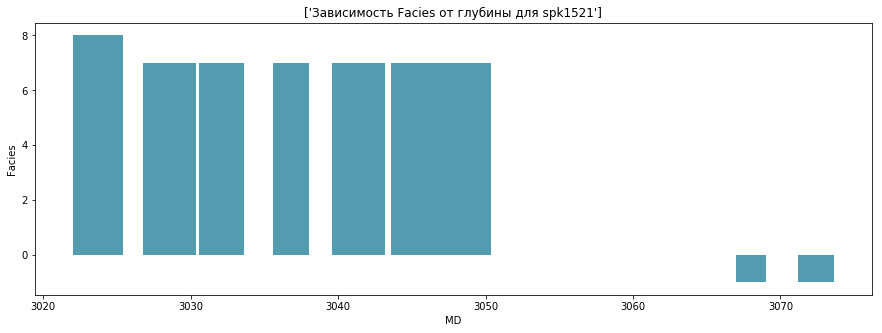

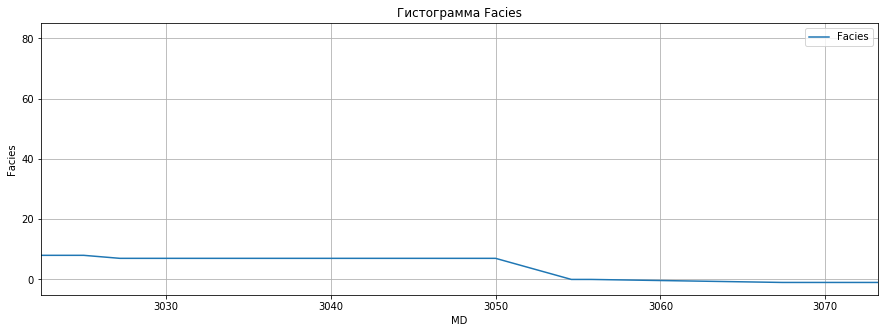

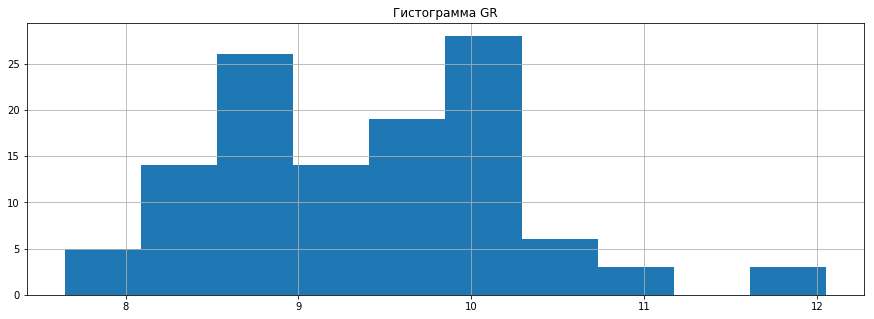

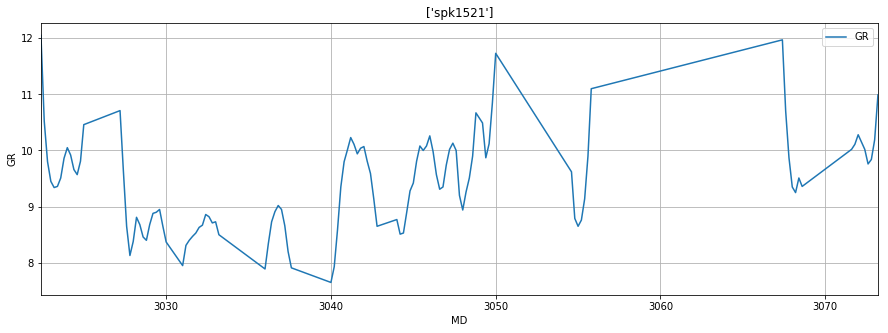

['Скважина - spk1527']
Статистика по всем значениям


MD           BK       Facies           GR     LIT  \
count  1370.000000  1370.000000  1370.000000  1370.000000  1370.0   
mean   2271.314745     6.074825    -0.581752     6.908964     4.0   
std     186.963197     4.236545     1.775851     1.051555     0.0   
min    2004.000000     1.870000    -1.000000     4.450000     4.0   
25%    2150.450000     4.392500    -1.000000     6.090000     4.0   
50%    2219.100000     5.090000    -1.000000     6.790000     4.0   
75%    2398.950000     6.347500    -1.000000     7.557500     4.0   
max    2729.600000    85.950000     8.000000    10.840000     4.0   

              NKTB           SP  
count  1370.000000  1370.000000  
mean      3.373942    69.439015  
std       0.525041    12.899633  
min       1.860000    45.710000  
25%       3.060000    58.870000  
50%       3.270000    68.075000  
75%       3.570000    77.747500  
max       7.930000   106.630000

Статистика по известным значениям Facies


MD         BK     Facies         GR   LIT       NKTB  \
count    86.000000  86.000000  86.000000  86.000000  86.0  86.000000   
mean   2693.890698  15.279419   5.662791   5.716628   4.0   4.323372   
std       7.934891   5.322073   2.949020   0.557983   0.0   0.398210   
min    2682.000000   5.810000   0.000000   4.840000   4.0   3.570000   
25%    2688.050000  10.690000   7.000000   5.380000   4.0   4.125000   
50%    2693.700000  16.140000   7.000000   5.600000   4.0   4.280000   
75%    2698.100000  19.005000   7.000000   5.825000   4.0   4.535000   
max    2713.000000  27.290000   8.000000   8.090000   4.0   5.640000   

              SP  
count  86.000000  
mean   60.384767  
std     6.260759  
min    52.900000  
25%    56.712500  
50%    57.795000  
75%    61.537500  
max    77.910000

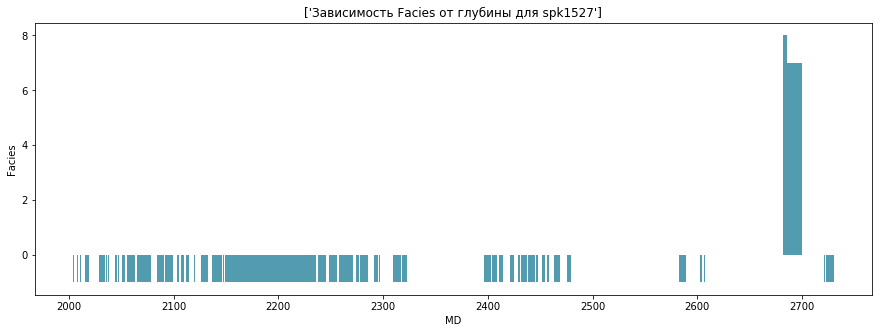

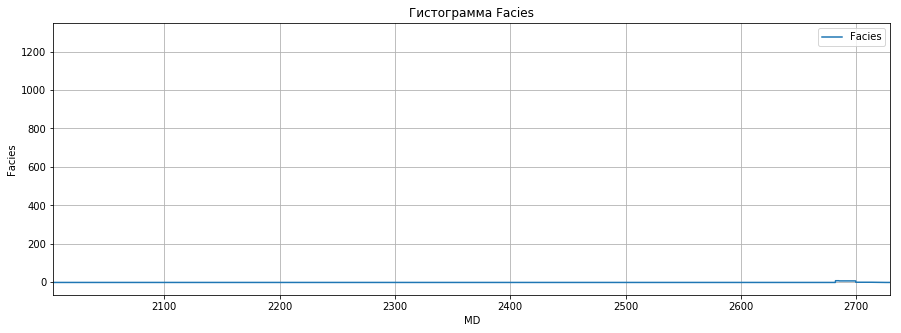

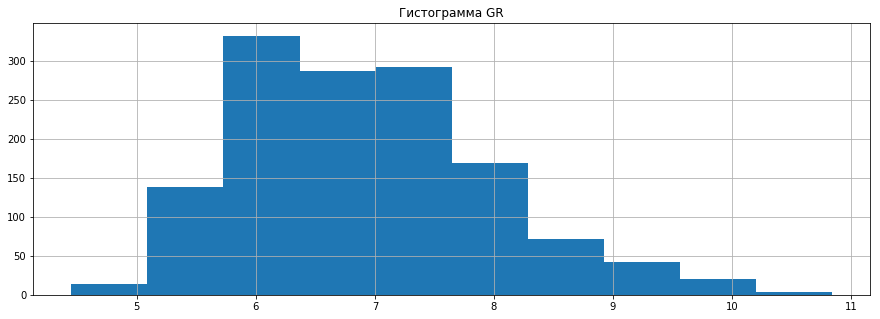

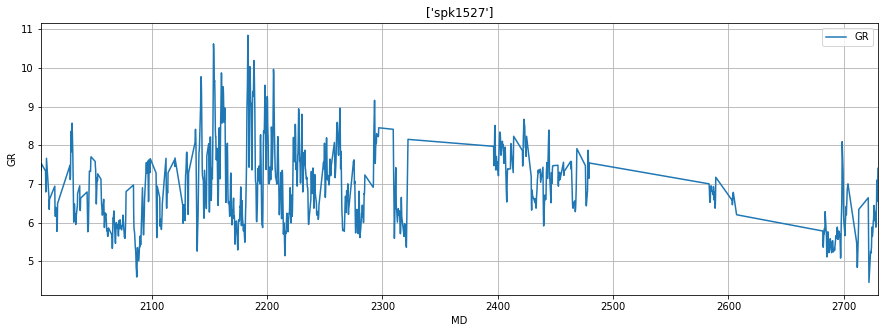

['Скважина - spk1769']
Статистика по всем значениям


MD           BK       Facies           GR     LIT  \
count  1029.000000  1029.000000  1029.000000  1029.000000  1029.0   
mean   2269.674830     8.655423    -0.762877  -177.420641     4.0   
std     209.955859     4.610645     1.057741  1347.748038     0.0   
min    2000.000000     3.270000    -1.000000 -9999.000000     4.0   
25%    2090.200000     6.120000    -1.000000     6.570000     4.0   
50%    2200.600000     7.910000    -1.000000     7.240000     4.0   
75%    2492.200000    10.040000    -1.000000     7.950000     4.0   
max    2662.600000    91.580000     5.000000    10.790000     4.0   

              NKTB           SP  
count  1029.000000  1029.000000  
mean   -181.644985    90.976433  
std    1347.168060    22.405066  
min   -9999.000000    59.550000  
25%       2.620000    69.330000  
50%       2.930000    87.470000  
75%       3.360000   113.560000  
max       6.730000   129.980000

Статистика по известным значениям Facies


MD         BK     Facies         GR   LIT       NKTB  \
count    62.000000  62.000000  62.000000  62.000000  62.0  62.000000   
mean   2595.432258  12.351613   2.935484   6.582581   4.0   3.607258   
std       6.684574   2.898429   2.015277   1.370820   0.0   0.375666   
min    2582.800000   3.750000   1.000000   4.060000   4.0   2.770000   
25%    2592.850000   9.502500   1.000000   5.375000   4.0   3.265000   
50%    2596.900000  13.355000   1.000000   6.455000   4.0   3.665000   
75%    2599.950000  14.167500   5.000000   7.645000   4.0   3.880000   
max    2607.200000  17.190000   5.000000   9.700000   4.0   4.350000   

               SP  
count   62.000000  
mean   101.408710  
std     19.566809  
min     77.010000  
25%     81.100000  
50%    106.485000  
75%    120.082500  
max    128.380000

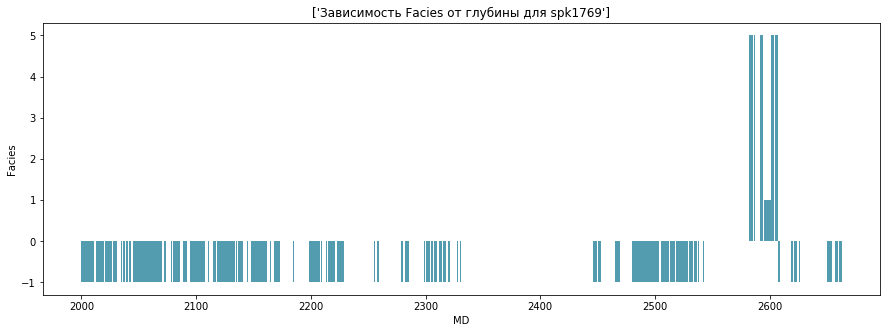

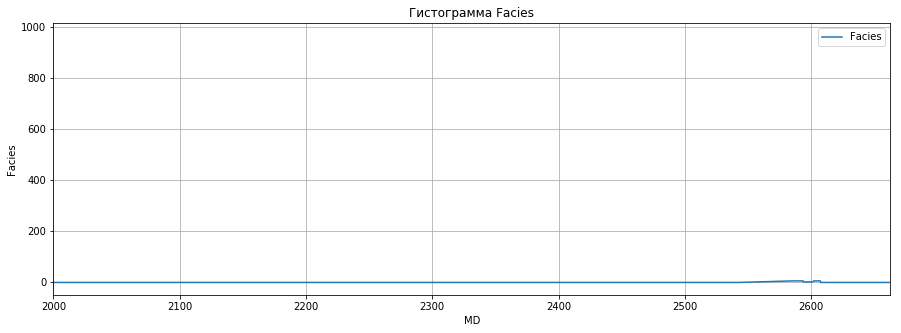

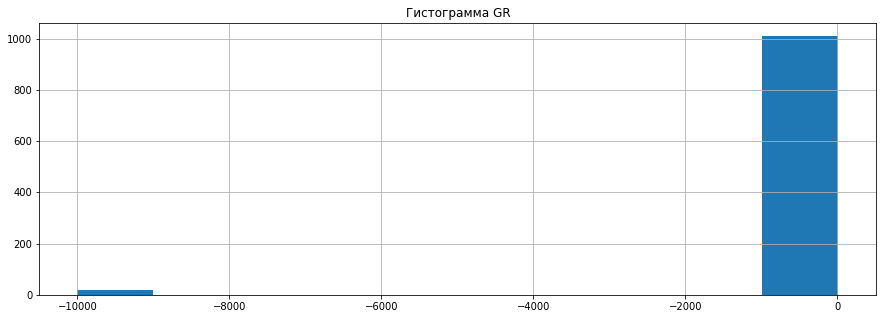

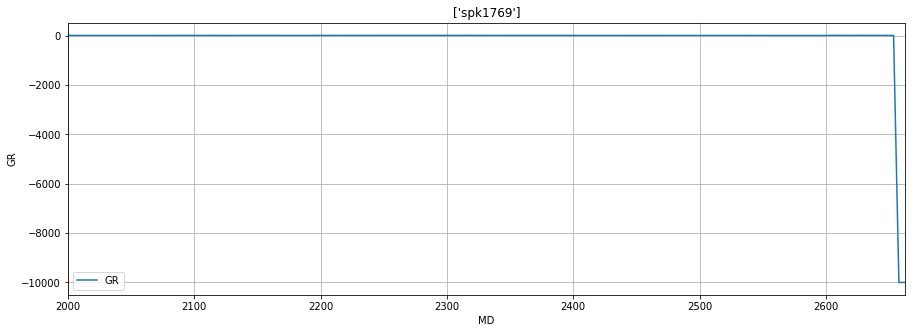

['Скважина - spk400']
Статистика по всем значениям


MD         BK     Facies         GR   LIT       NKTB  \
count    83.000000  83.000000  83.000000  83.000000  83.0  83.000000   
mean   2539.450602  15.361446   6.807229   6.106928   4.0   4.545400   
std       6.526202   2.533413   0.593827   0.446904   0.0   0.228506   
min    2532.700000   9.570000   5.000000   4.780000   4.0   3.856798   
25%    2534.750000  13.590000   7.000000   5.872500   4.0   4.419495   
50%    2539.000000  15.650000   7.000000   6.050000   4.0   4.613760   
75%    2541.050000  17.160000   7.000000   6.510000   4.0   4.720940   
max    2557.400000  20.460000   7.000000   6.950000   4.0   4.881711   

               SP  
count   83.000000  
mean    96.032421  
std      6.004532  
min     87.790760  
25%     90.313530  
50%     94.883330  
75%    101.204800  
max    106.967800

Статистика по известным значениям Facies


MD         BK     Facies         GR   LIT       NKTB  \
count    83.000000  83.000000  83.000000  83.000000  83.0  83.000000   
mean   2539.450602  15.361446   6.807229   6.106928   4.0   4.545400   
std       6.526202   2.533413   0.593827   0.446904   0.0   0.228506   
min    2532.700000   9.570000   5.000000   4.780000   4.0   3.856798   
25%    2534.750000  13.590000   7.000000   5.872500   4.0   4.419495   
50%    2539.000000  15.650000   7.000000   6.050000   4.0   4.613760   
75%    2541.050000  17.160000   7.000000   6.510000   4.0   4.720940   
max    2557.400000  20.460000   7.000000   6.950000   4.0   4.881711   

               SP  
count   83.000000  
mean    96.032421  
std      6.004532  
min     87.790760  
25%     90.313530  
50%     94.883330  
75%    101.204800  
max    106.967800

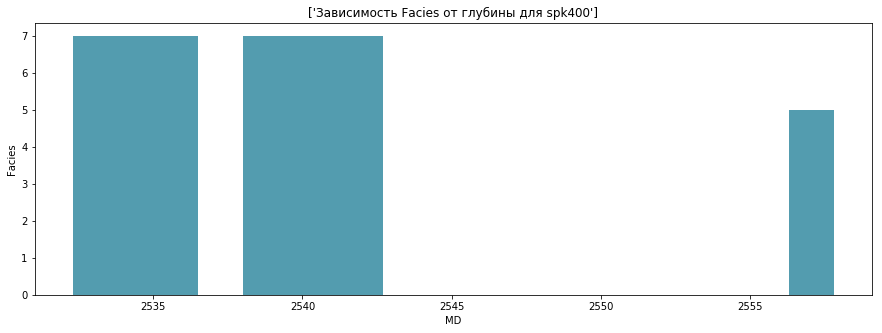

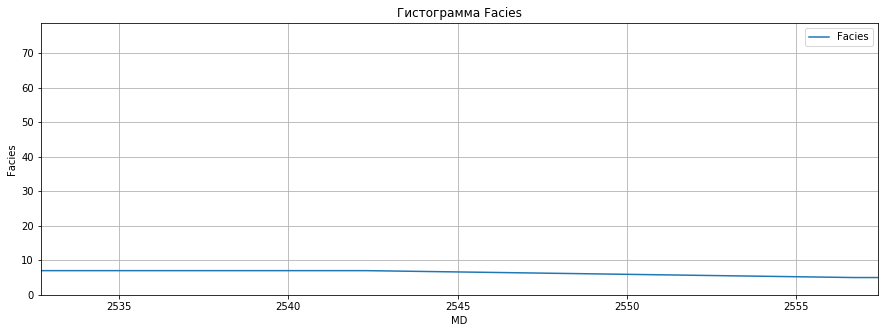

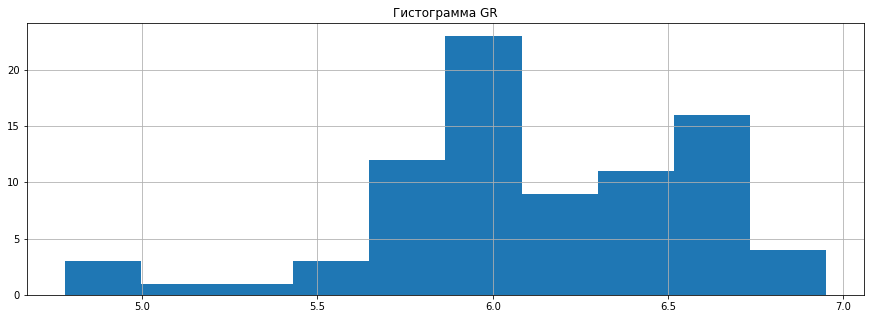

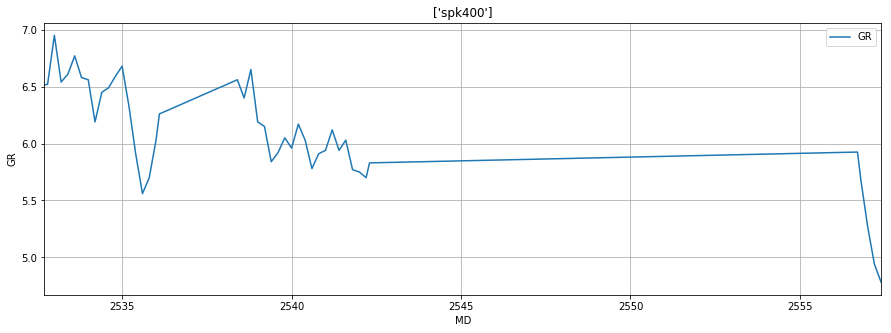

['Скважина - spk403']
Статистика по всем значениям


MD         BK     Facies         GR   LIT       NKTB  \
count    41.000000  41.000000  41.000000  41.000000  41.0  41.000000   
mean   2601.804878  11.536585   0.317073   6.087073   4.0   4.393116   
std      39.376808   2.270105   3.220551   0.536811   0.0   0.203872   
min    2528.400000   7.700000  -1.000000   5.040000   4.0   4.113792   
25%    2569.600000  10.200000  -1.000000   5.750000   4.0   4.210251   
50%    2628.400000  11.500000  -1.000000   6.200000   4.0   4.385631   
75%    2630.400000  13.100000  -1.000000   6.470000   4.0   4.499627   
max    2632.400000  17.300000   8.000000   7.500000   4.0   4.850386   

              SP  
count  41.000000  
mean   54.167940  
std     3.102853  
min    48.496480  
25%    51.398640  
50%    54.296090  
75%    56.958450  
max    59.175730

Статистика по известным значениям Facies


MD         BK  Facies        GR  LIT      NKTB         SP
count     6.000000   6.000000     6.0  6.000000  6.0  6.000000   6.000000
mean   2528.900000  13.500000     8.0  5.765000  4.0  4.704236  57.379818
std       0.374166   3.470447     0.0  0.407222  0.0  0.137051   0.641772
min    2528.400000   7.700000     8.0  5.230000  4.0  4.499627  56.757100
25%    2528.650000  12.300000     8.0  5.490000  4.0  4.622393  56.876058
50%    2528.900000  13.850000     8.0  5.755000  4.0  4.718851  57.205245
75%    2529.150000  15.850000     8.0  6.042500  4.0  4.815310  57.810365
max    2529.400000  17.300000     8.0  6.310000  4.0  4.850386  58.332920

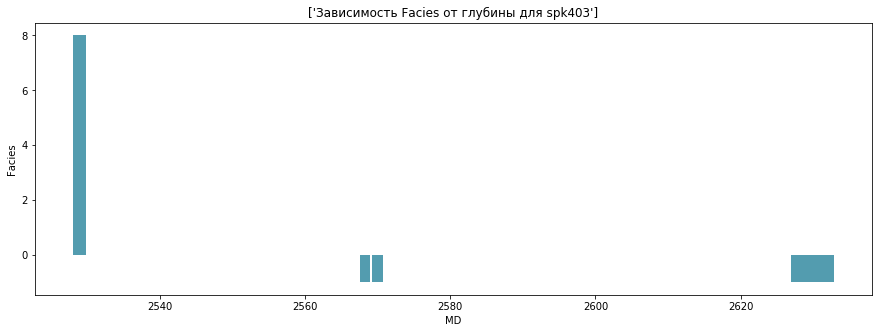

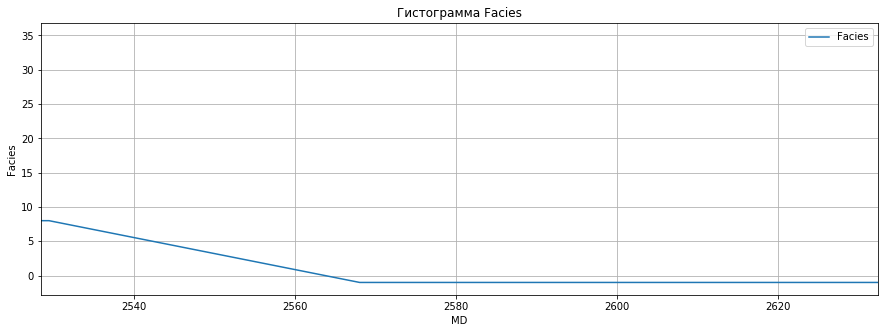

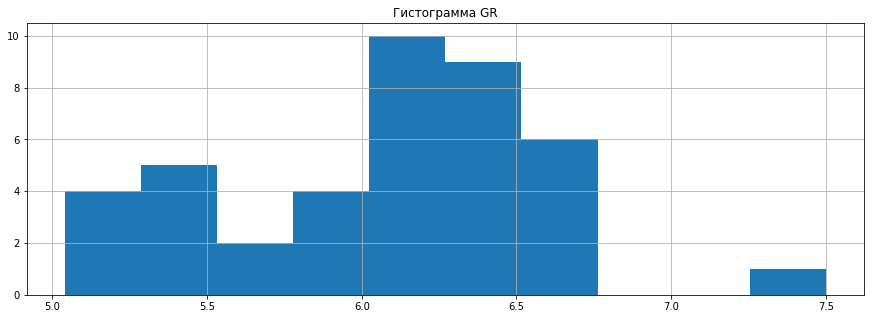

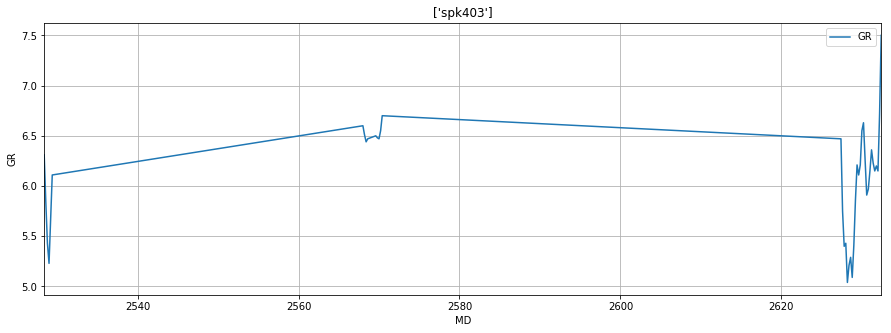

['Скважина - spk405R']
Статистика по всем значениям


MD         BK     Facies         GR   LIT      NKTB  \
count    30.000000  30.000000  30.000000  30.000000  30.0  30.00000   
mean   2525.813333  10.596667   9.066667  10.263333   4.0   4.39325   
std      12.749354   3.117745   4.517654   0.633264   0.0   0.21563   
min    2507.000000   6.500000  -1.000000   9.000000   4.0   3.86500   
25%    2509.450000   8.600000   5.000000   9.700000   4.0   4.32250   
50%    2533.900000   9.000000  12.000000  10.400000   4.0   4.43500   
75%    2535.350000  12.275000  12.000000  10.700000   4.0   4.54750   
max    2536.800000  19.300000  12.000000  11.900000   4.0   4.72000   

               SP  
count   30.000000  
mean   115.356200  
std      5.401736  
min    109.355900  
25%    110.640650  
50%    113.378450  
75%    118.781100  
max    125.184400

Статистика по известным значениям Facies


MD         BK     Facies         GR   LIT       NKTB  \
count    27.000000  27.000000  27.000000  27.000000  27.0  27.000000   
mean   2527.881481  10.711111  10.185185  10.177778   4.0   4.376944   
std      11.699607   3.173367   3.126033   0.598931   0.0   0.220970   
min    2507.600000   8.000000   5.000000   9.000000   4.0   3.865000   
25%    2520.700000   8.600000   8.500000   9.700000   4.0   4.266250   
50%    2534.200000   9.000000  12.000000  10.400000   4.0   4.405000   
75%    2535.500000  12.450000  12.000000  10.400000   4.0   4.547500   
max    2536.800000  19.300000  12.000000  11.900000   4.0   4.720000   

               SP  
count   27.000000  
mean   115.540007  
std      5.665165  
min    109.355900  
25%    110.549450  
50%    113.388300  
75%    121.033600  
max    125.184400

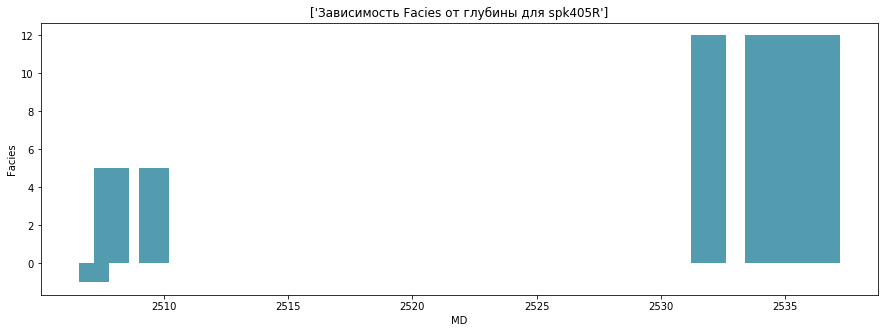

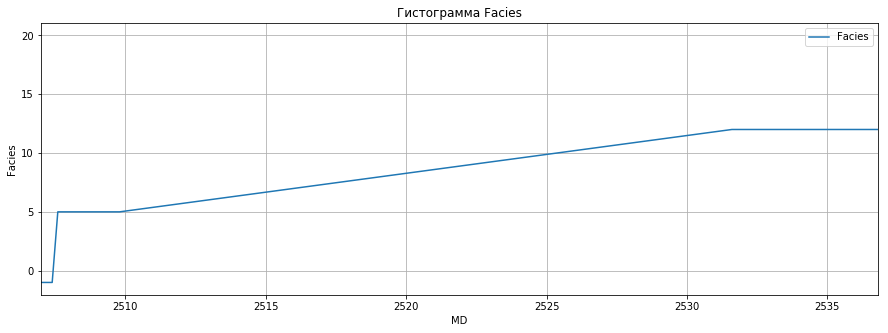

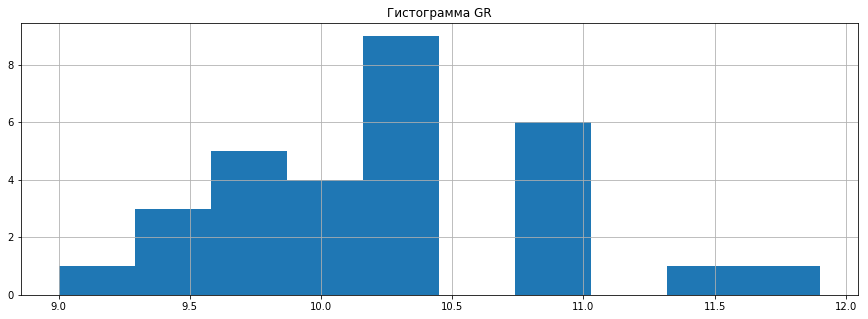

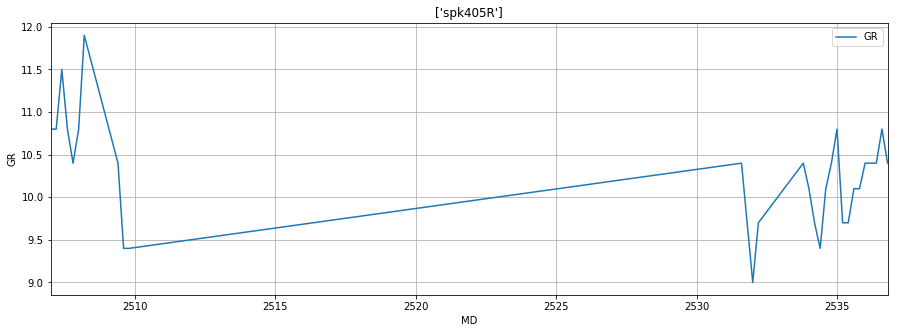

['Скважина - spk406R']
Статистика по всем значениям


MD         BK  Facies         GR   LIT       NKTB         SP
count    18.000000  18.000000    18.0  18.000000  18.0  18.000000  18.000000
mean   2604.500000   7.283333    -1.0   8.133333   4.0   5.671402  68.729911
std       1.067708   0.719681     0.0   0.481419   0.0   0.451920   0.968550
min    2602.800000   6.250000    -1.0   7.400000   4.0   4.622116  67.585110
25%    2603.650000   6.662500    -1.0   7.800000   4.0   5.511493  68.248355
50%    2604.500000   7.150000    -1.0   8.200000   4.0   5.721710  68.402550
75%    2605.350000   7.987500    -1.0   8.550000   4.0   6.020864  68.989323
max    2606.200000   8.300000    -1.0   9.000000   4.0   6.271506  71.420490

Статистика по известным значениям Facies


MD   BK  Facies   GR  LIT  NKTB   SP
count  0.0  0.0     0.0  0.0  0.0   0.0  0.0
mean   NaN  NaN     NaN  NaN  NaN   NaN  NaN
std    NaN  NaN     NaN  NaN  NaN   NaN  NaN
min    NaN  NaN     NaN  NaN  NaN   NaN  NaN
25%    NaN  NaN     NaN  NaN  NaN   NaN  NaN
50%    NaN  NaN     NaN  NaN  NaN   NaN  NaN
75%    NaN  NaN     NaN  NaN  NaN   NaN  NaN
max    NaN  NaN     NaN  NaN  NaN   NaN  NaN

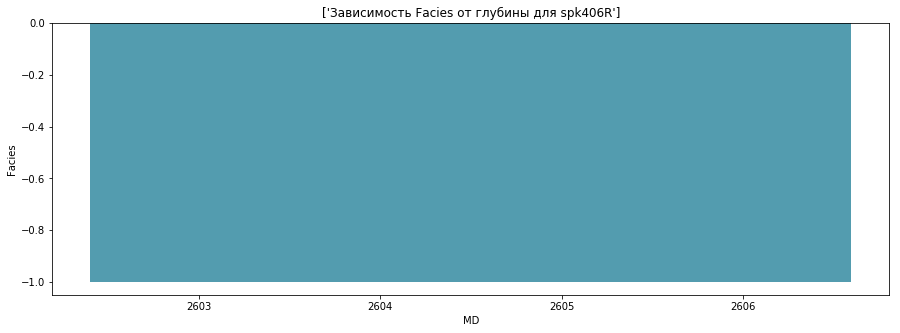

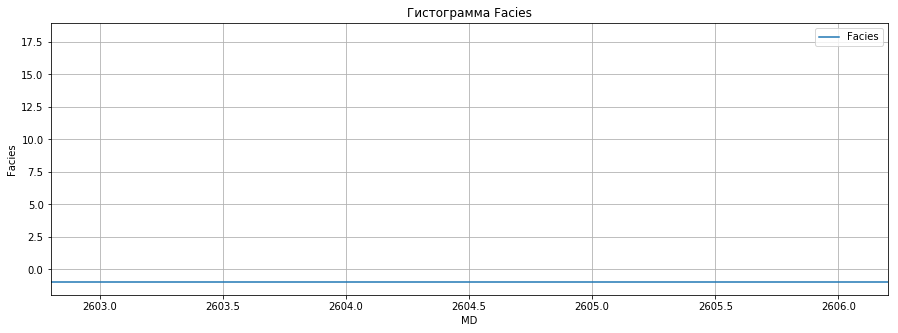

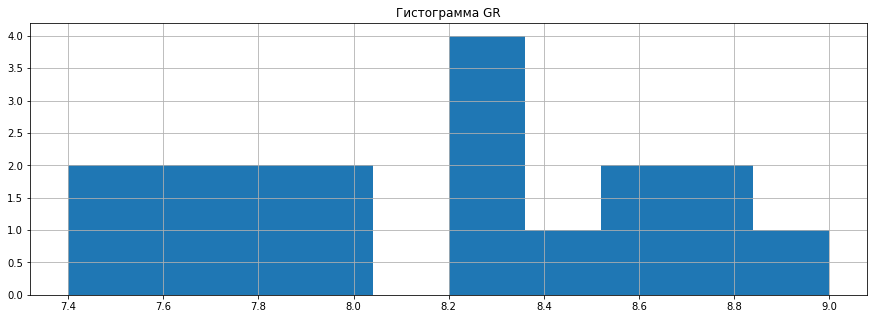

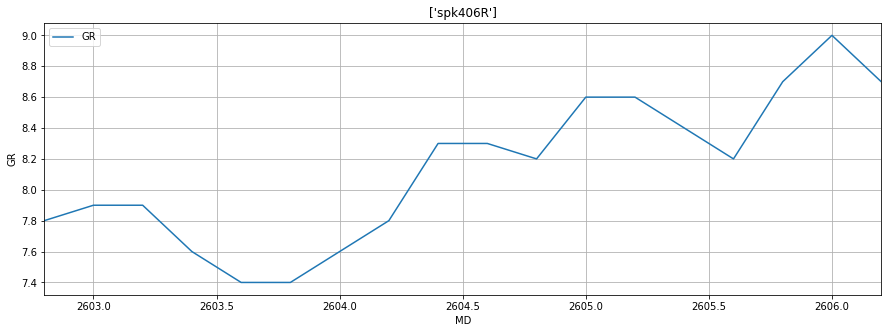

['Скважина - spk409R']
Статистика по всем значениям


MD         BK     Facies         GR   LIT       NKTB  \
count    32.000000  32.000000  32.000000  32.000000  32.0  32.000000   
mean   2569.312500   8.693750   3.468750   4.312500   4.0   4.042330   
std      26.346228   1.078511   3.877016   1.147606   0.0   0.464202   
min    2548.000000   7.200000  -1.000000   2.520000   4.0   2.900339   
25%    2550.350000   7.900000   1.000000   3.500000   4.0   3.840325   
50%    2564.300000   8.300000   1.000000   4.360000   4.0   4.118154   
75%    2565.850000   9.800000   8.000000   5.050000   4.0   4.361254   
max    2621.800000  11.200000   8.000000   6.920000   4.0   4.641399   

              SP  
count  32.000000  
mean   71.042033  
std    11.488844  
min    49.395160  
25%    64.170160  
50%    72.645155  
75%    81.495160  
max    86.095150

Статистика по известным значениям Facies


MD         BK     Facies         GR   LIT       NKTB  \
count    26.000000  26.000000  26.000000  26.000000  26.0  26.000000   
mean   2557.315385   8.776923   4.500000   4.501538   4.0   4.195092   
std       7.896161   1.099930   3.569314   1.113710   0.0   0.274550   
min    2548.000000   7.600000   1.000000   2.560000   4.0   3.733825   
25%    2550.050000   7.900000   1.000000   3.700000   4.0   3.997762   
50%    2557.500000   8.300000   4.500000   4.600000   4.0   4.169090   
75%    2564.950000  10.000000   8.000000   5.110000   4.0   4.465440   
max    2566.200000  11.200000   8.000000   6.920000   4.0   4.641399   

              SP  
count  26.000000  
mean   69.729773  
std    12.275925  
min    49.395160  
25%    59.520160  
50%    72.195160  
75%    81.345160  
max    86.095150

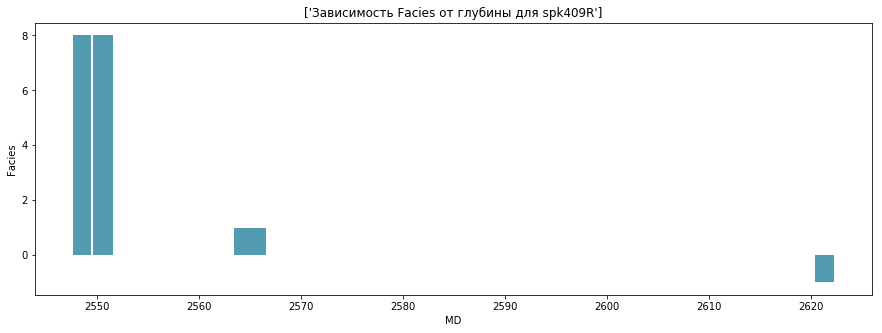

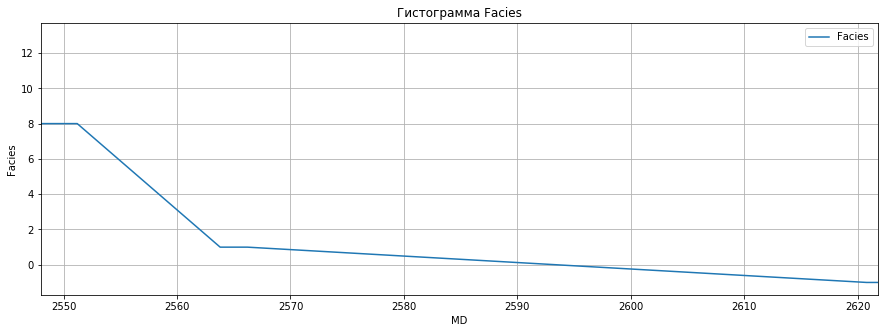

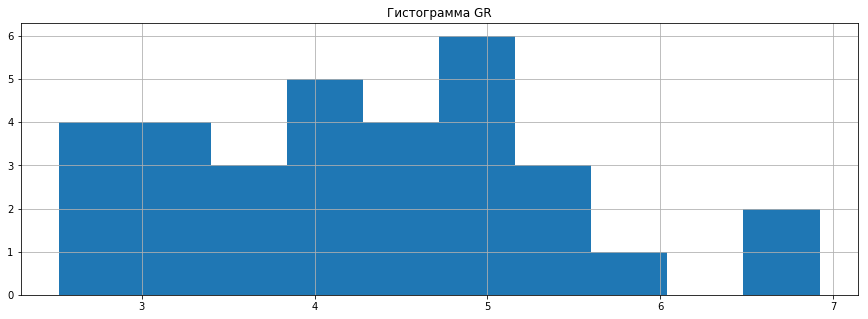

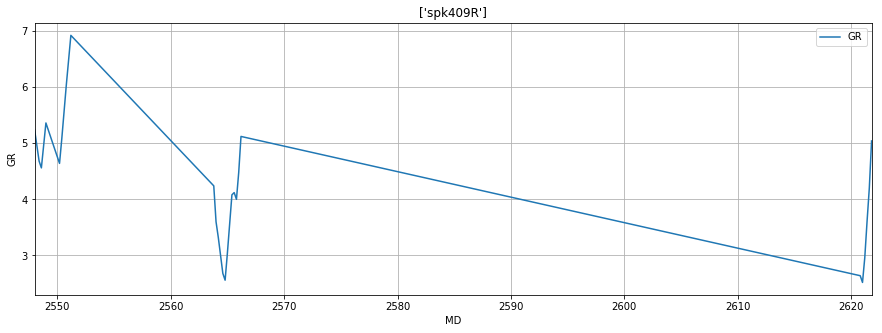

['Скважина - spk420R']
Статистика по всем значениям


MD         BK     Facies         GR   LIT       NKTB         SP
count    64.00000  64.000000  64.000000  64.000000  64.0  64.000000  64.000000
mean   2570.62500   9.368047   2.984375   7.344844   4.0   4.590745  93.475872
std      12.46687   2.751482   2.814318   0.998656   0.0   0.417709   2.654858
min    2550.60000   5.740000  -1.000000   5.670000   4.0   3.891901  89.184360
25%    2561.75000   7.580000   0.000000   6.655000   4.0   4.278536  91.653103
50%    2573.30000   8.800000   3.000000   7.255000   4.0   4.549182  93.150395
75%    2582.85000  10.810000   3.000000   7.840000   4.0   4.786962  94.717318
max    2589.60000  20.430000   8.000000   9.890000   4.0   5.662693  99.437400

Статистика по известным значениям Facies


MD         BK     Facies         GR   LIT       NKTB  \
count    60.000000  60.000000  60.000000  60.000000  60.0  60.000000   
mean   2569.380000   9.563250   3.250000   7.308000   4.0   4.620065   
std      11.863215   2.723315   2.703576   1.010272   0.0   0.414547   
min    2550.600000   5.740000   0.000000   5.670000   4.0   3.891901   
25%    2561.550000   7.916250   2.250000   6.555000   4.0   4.388728   
50%    2572.900000   8.945000   3.000000   7.205000   4.0   4.583979   
75%    2577.450000  10.990000   3.000000   7.752500   4.0   4.829492   
max    2587.600000  20.430000   8.000000   9.890000   4.0   5.662693   

              SP  
count  60.000000  
mean   93.559888  
std     2.650247  
min    89.184360  
25%    91.895093  
50%    93.261090  
75%    94.717318  
max    99.437400

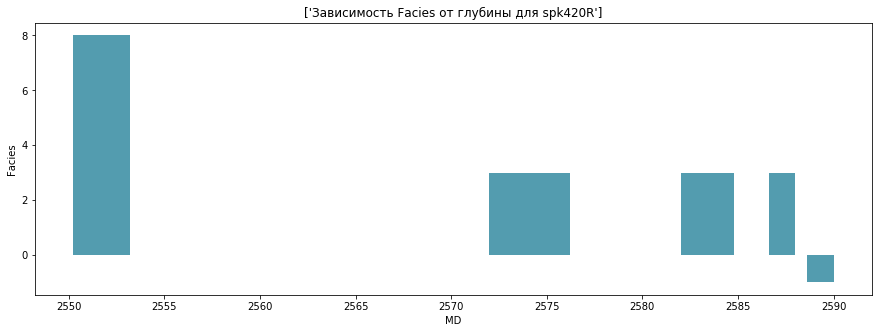

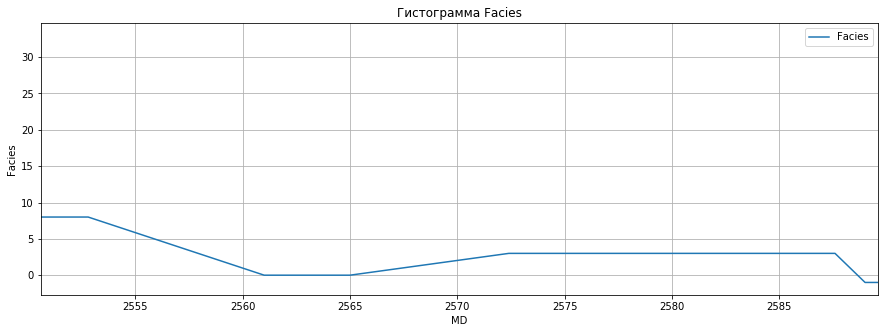

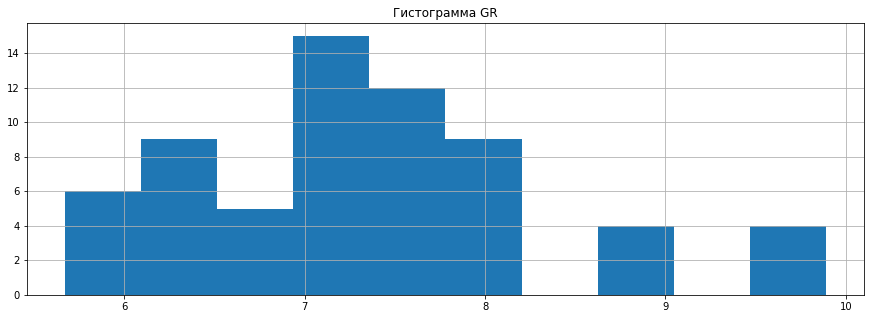

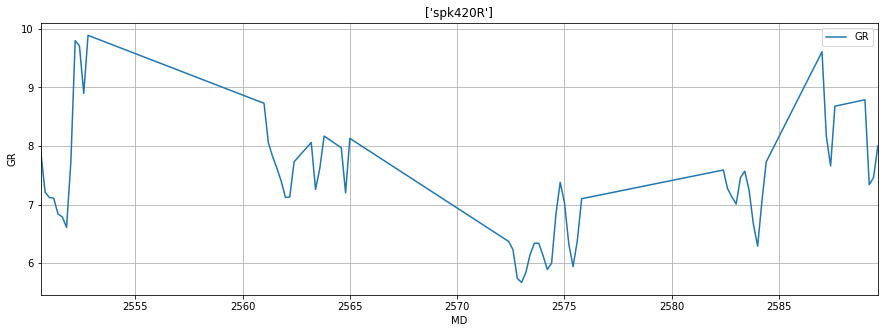

['Скважина - spk424R']
Статистика по всем значениям


MD         BK     Facies         GR   LIT       NKTB  \
count    27.000000  27.000000  27.000000  27.000000  27.0  27.000000   
mean   2556.429630  15.295519   7.481481   7.665519   4.0   4.970876   
std      11.778429   3.863267   4.273085   0.885087   0.0   0.401244   
min    2542.400000   9.130000  -1.000000   6.352000   4.0   4.185875   
25%    2545.500000  12.095500   7.000000   7.089500   4.0   4.736035   
50%    2548.200000  14.951000   7.000000   7.499000   4.0   4.889658   
75%    2568.700000  17.801500  12.000000   8.087500   4.0   5.283699   
max    2570.000000  22.256001  12.000000   9.579000   4.0   5.632817   

               SP  
count   27.000000  
mean   158.989167  
std      5.354604  
min    144.490300  
25%    155.454550  
50%    159.957200  
75%    162.837100  
max    165.559800

Статистика по известным значениям Facies


MD         BK     Facies         GR   LIT       NKTB  \
count    23.000000  23.000000  23.000000  23.000000  23.0  23.000000   
mean   2554.713043  14.461087   8.956522   7.832304   4.0   4.919389   
std      11.964618   3.453229   2.495054   0.842555   0.0   0.407166   
min    2542.400000   9.130000   7.000000   6.494000   4.0   4.185875   
25%    2545.300000  12.064000   7.000000   7.274500   4.0   4.692222   
50%    2547.000000  13.780000   7.000000   7.684000   4.0   4.855273   
75%    2568.900000  17.413500  12.000000   8.325500   4.0   5.256801   
max    2570.000000  21.202000  12.000000   9.579000   4.0   5.632817   

              SP  
count   23.00000  
mean   159.93167  
std      3.96164  
min    153.18820  
25%    156.79010  
50%    160.84630  
75%    162.83710  
max    165.48230

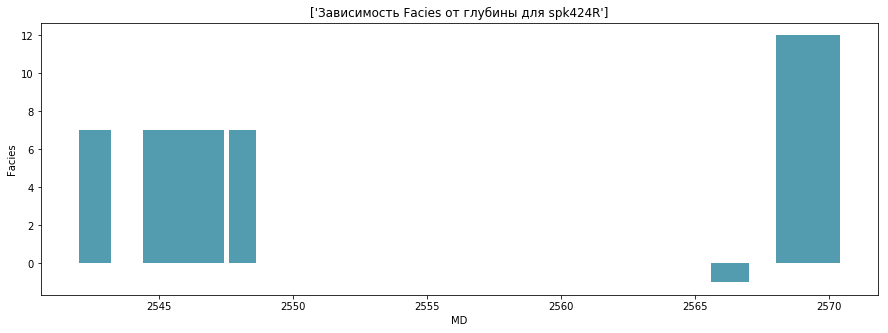

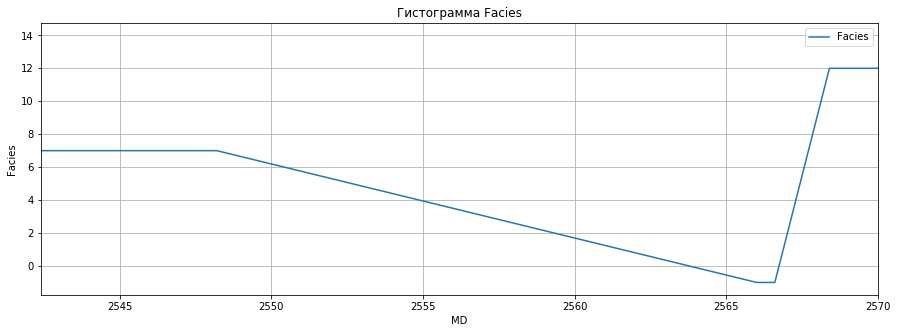

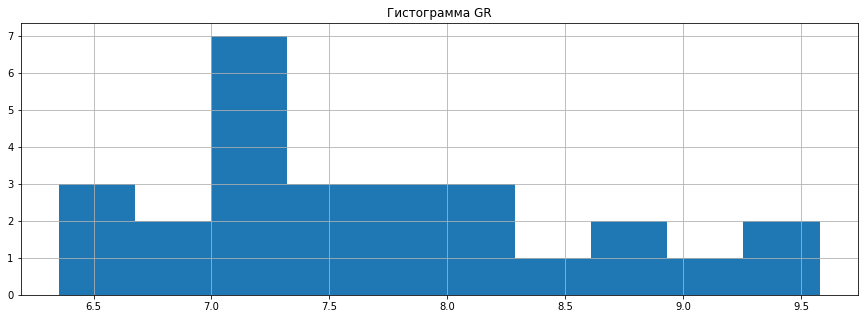

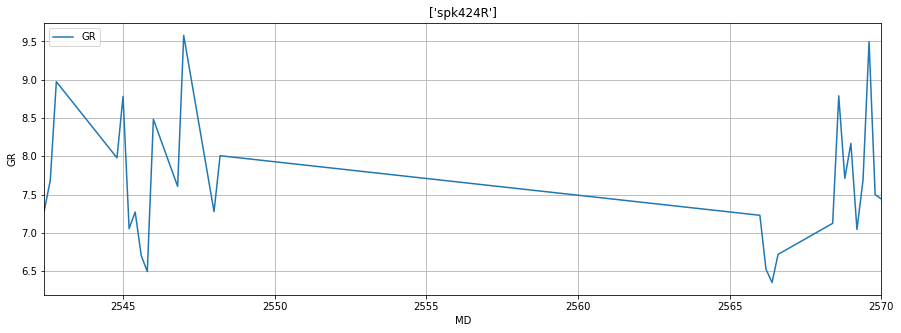

['Скважина - spk426R']
Статистика по всем значениям


MD         BK  Facies         GR   LIT       NKTB         SP
count    21.000000  21.000000    21.0  21.000000  21.0  21.000000  21.000000
mean   2573.514286   8.932905     1.0   5.910571   4.0   4.898745  65.817854
std       1.390786   2.270481     0.0   1.059464   0.0   0.256724  11.372783
min    2571.400000   4.881000     1.0   4.927000   4.0   4.287728  53.691840
25%    2572.400000   7.925000     1.0   5.413000   4.0   4.848731  56.524490
50%    2573.400000   9.561000     1.0   5.634000   4.0   5.001560  63.040700
75%    2574.800000  10.552000     1.0   5.831000   4.0   5.051874  72.057400
max    2575.800000  12.259000     1.0   9.147000   4.0   5.228602  91.545270

Статистика по известным значениям Facies


MD         BK  Facies         GR   LIT       NKTB         SP
count    21.000000  21.000000    21.0  21.000000  21.0  21.000000  21.000000
mean   2573.514286   8.932905     1.0   5.910571   4.0   4.898745  65.817854
std       1.390786   2.270481     0.0   1.059464   0.0   0.256724  11.372783
min    2571.400000   4.881000     1.0   4.927000   4.0   4.287728  53.691840
25%    2572.400000   7.925000     1.0   5.413000   4.0   4.848731  56.524490
50%    2573.400000   9.561000     1.0   5.634000   4.0   5.001560  63.040700
75%    2574.800000  10.552000     1.0   5.831000   4.0   5.051874  72.057400
max    2575.800000  12.259000     1.0   9.147000   4.0   5.228602  91.545270

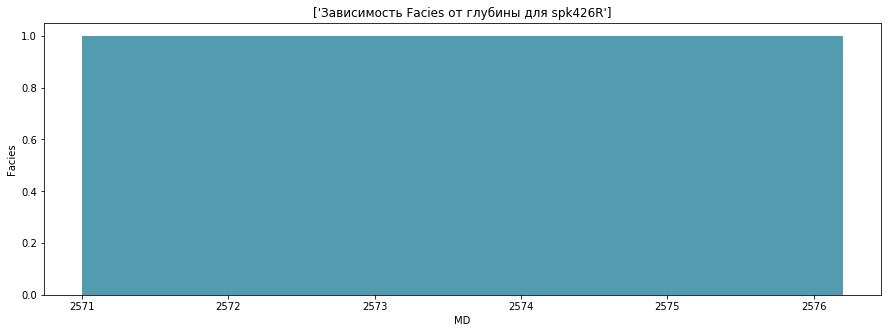

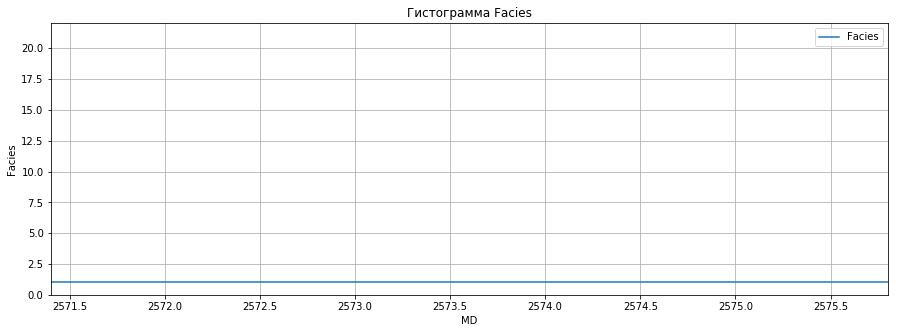

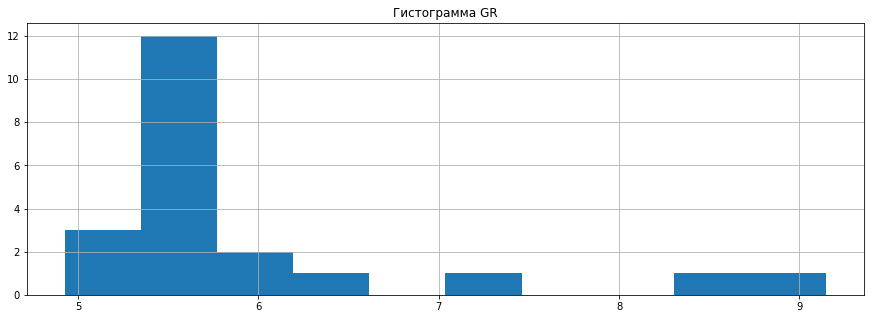

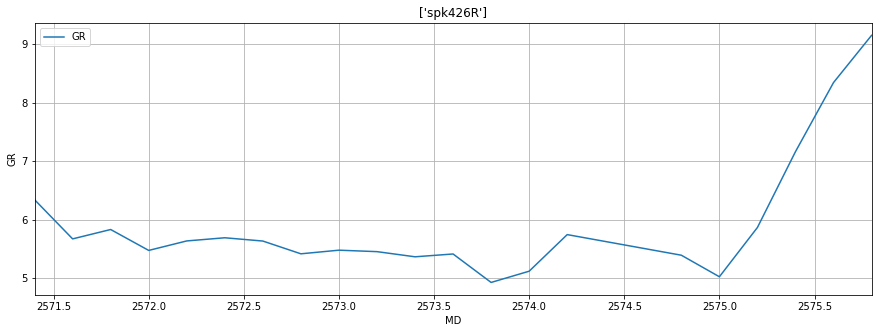

['Скважина - spk427R']
Статистика по всем значениям


MD         BK     Facies         GR   LIT       NKTB   SP
count    57.000000  57.000000  57.000000  57.000000  57.0  57.000000  0.0
mean   2573.722807   6.841912   3.789474   8.305263   4.0   4.446028  NaN
std      12.809971   6.045535   3.754696   1.001324   0.0   0.517792  NaN
min    2559.000000   4.181000   0.000000   6.200000   4.0   3.672621  NaN
25%    2562.200000   4.997000   0.000000   7.600000   4.0   3.965555  NaN
50%    2573.600000   5.640000   5.000000   8.300000   4.0   4.337534  NaN
75%    2579.600000   6.932000   8.000000   8.800000   4.0   4.983848  NaN
max    2600.800000  49.738000   8.000000  10.600000   4.0   5.537167  NaN

Статистика по известным значениям Facies


MD         BK     Facies         GR   LIT       NKTB   SP
count    57.000000  57.000000  57.000000  57.000000  57.0  57.000000  0.0
mean   2573.722807   6.841912   3.789474   8.305263   4.0   4.446028  NaN
std      12.809971   6.045535   3.754696   1.001324   0.0   0.517792  NaN
min    2559.000000   4.181000   0.000000   6.200000   4.0   3.672621  NaN
25%    2562.200000   4.997000   0.000000   7.600000   4.0   3.965555  NaN
50%    2573.600000   5.640000   5.000000   8.300000   4.0   4.337534  NaN
75%    2579.600000   6.932000   8.000000   8.800000   4.0   4.983848  NaN
max    2600.800000  49.738000   8.000000  10.600000   4.0   5.537167  NaN

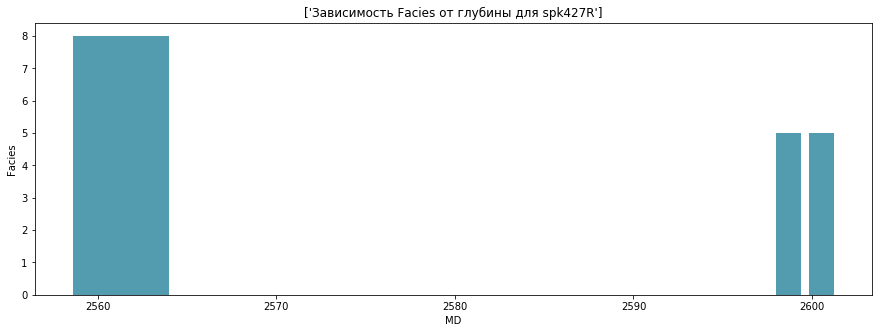

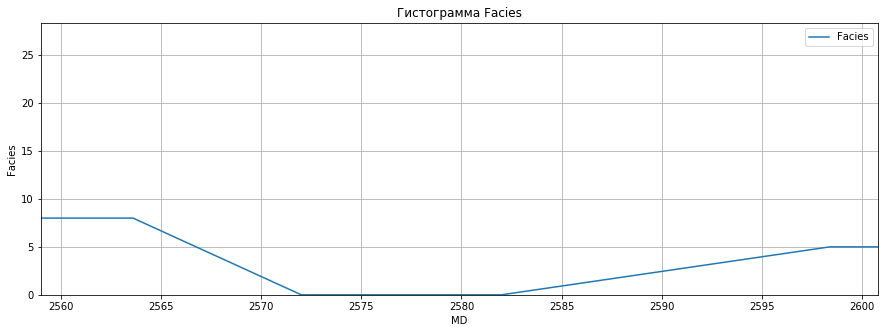

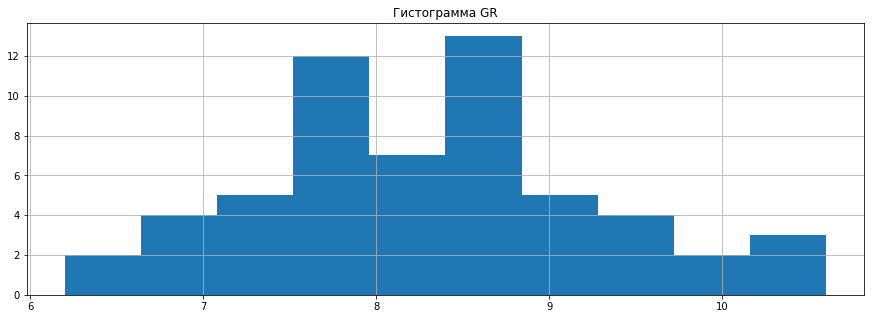

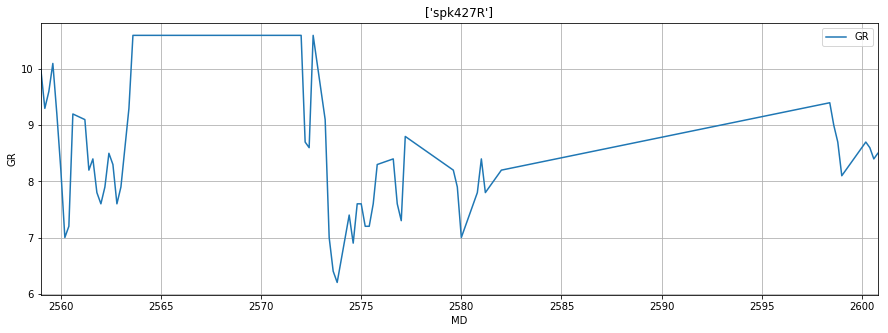

['Скважина - spk428R']
Статистика по всем значениям


MD         BK     Facies         GR   LIT       NKTB  \
count    76.000000  76.000000  76.000000  76.000000  76.0  76.000000   
mean   2620.747368   9.521447   1.460526   7.675789   4.0   4.773395   
std      30.253125   2.276282   3.575624   1.043391   0.0   0.509966   
min    2581.600000   5.890000  -1.000000   5.730000   4.0   3.749000   
25%    2594.950000   7.557500  -1.000000   6.915000   4.0   4.412250   
50%    2608.300000   8.920000  -1.000000   7.875000   4.0   4.869000   
75%    2650.650000  11.205000   7.000000   8.352500   4.0   5.194500   
max    2672.800000  16.330000   7.000000  10.500000   4.0   5.877000   

               SP  
count   76.000000  
mean   125.578610  
std     18.313174  
min     84.717560  
25%    114.333725  
50%    131.440000  
75%    140.932350  
max    146.799600

Статистика по известным значениям Facies


MD         BK     Facies         GR   LIT       NKTB  \
count    33.000000  33.000000  33.000000  33.000000  33.0  33.000000   
mean   2599.018182   8.475152   4.666667   8.300000   4.0   5.009212   
std      11.871222   2.263787   3.350995   0.530053   0.0   0.419849   
min    2581.600000   5.890000   0.000000   7.210000   4.0   3.938000   
25%    2583.200000   7.300000   0.000000   7.980000   4.0   4.736000   
50%    2605.800000   7.730000   7.000000   8.210000   4.0   5.142000   
75%    2608.200000   8.770000   7.000000   8.680000   4.0   5.282000   
max    2609.800000  16.330000   7.000000   9.430000   4.0   5.877000   

               SP  
count   33.000000  
mean   140.625779  
std      3.981676  
min    132.504900  
25%    137.745900  
50%    141.727400  
75%    143.681900  
max    146.799600

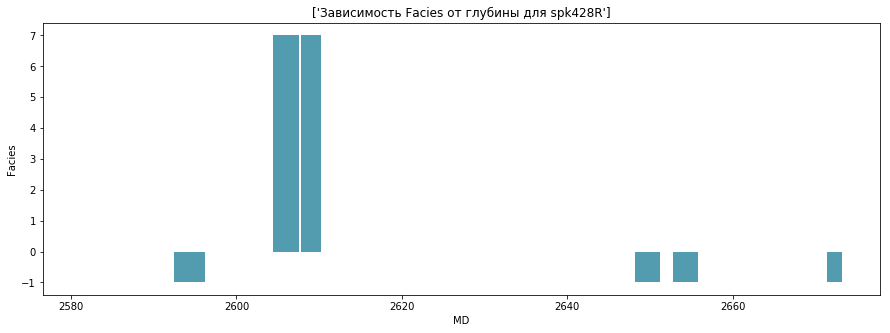

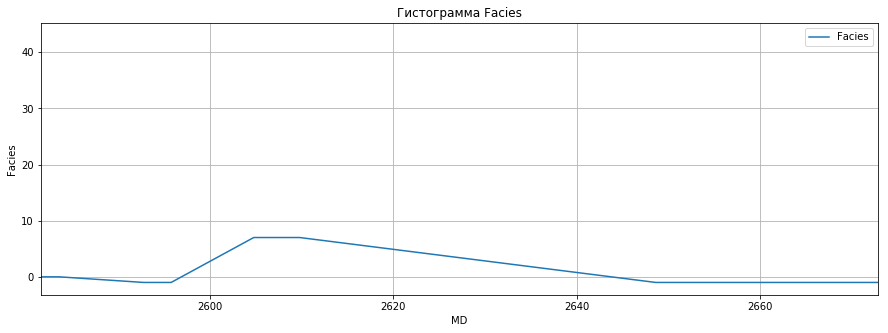

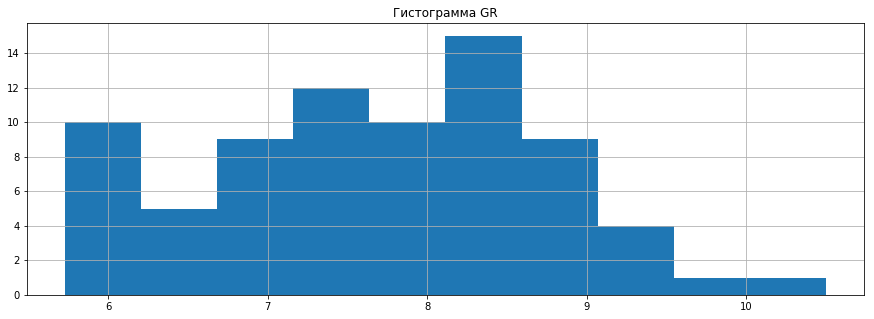

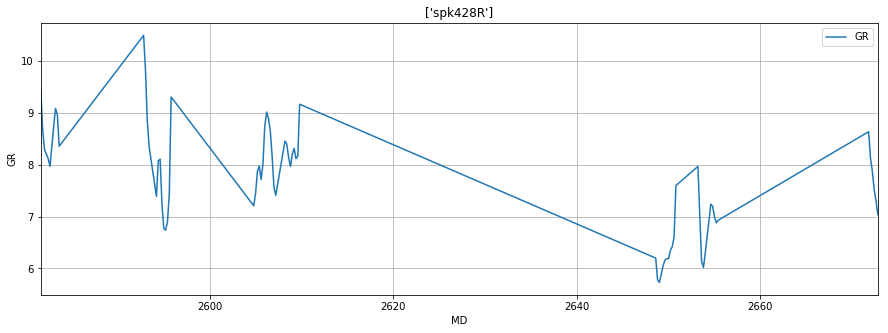

['Скважина - spk429L']
Статистика по всем значениям


MD          BK      Facies          GR    LIT        NKTB  \
count   119.000000  119.000000  119.000000  119.000000  119.0  119.000000   
mean   2596.238655   10.321950    2.831933    7.726471    4.0    4.906121   
std      36.534741    4.091639    4.013366    1.036150    0.0    0.418231   
min    2546.600000    4.683000   -1.000000    5.060000    4.0    4.090785   
25%    2574.700000    7.341000   -1.000000    7.058500    4.0    4.653757   
50%    2591.200000    9.815001   -1.000000    7.911000    4.0    4.844265   
75%    2617.700000   11.881500    7.000000    8.416500    4.0    5.205089   
max    2695.200000   28.359000    7.000000   10.171000    4.0    6.192547   

                SP  
count   119.000000  
mean   -336.612915  
std    2032.127138  
min   -9999.000000  
25%      85.221820  
50%      87.778780  
75%      90.039095  
max      98.553790

Статистика по известным значениям Facies


MD         BK  Facies         GR   LIT       NKTB         SP
count    57.000000  57.000000    57.0  57.000000  57.0  57.000000  57.000000
mean   2568.670175   9.948456     7.0   8.083895   4.0   4.909576  87.926158
std      16.044514   4.945442     0.0   0.996794   0.0   0.508386   3.796703
min    2546.600000   4.683000     7.0   5.690000   4.0   4.161098  77.529530
25%    2549.400000   7.055000     7.0   7.612000   4.0   4.457073  86.565850
50%    2574.400000   8.588000     7.0   8.232000   4.0   4.797707  88.281950
75%    2581.000000  11.088000     7.0   8.753000   4.0   5.286091  89.664090
max    2589.200000  28.359000     7.0  10.171000   4.0   6.192547  98.553790

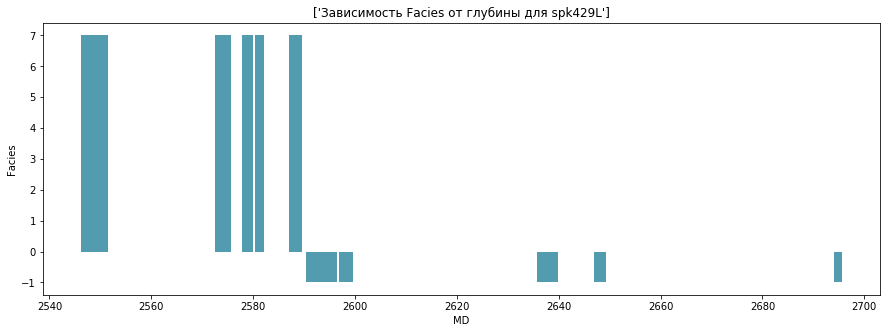

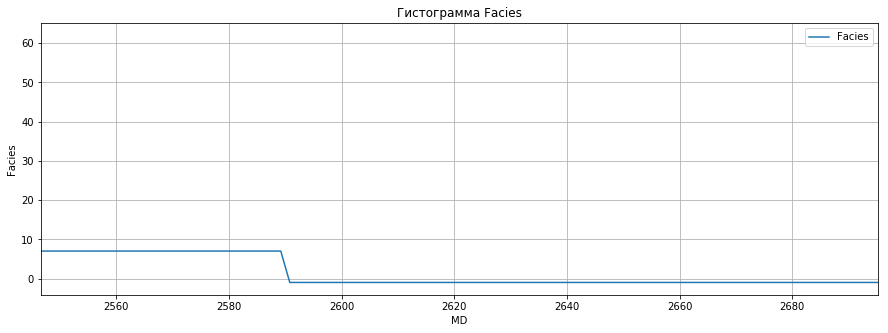

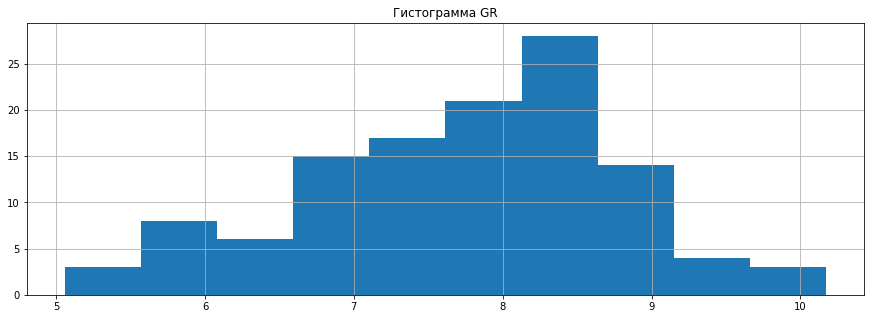

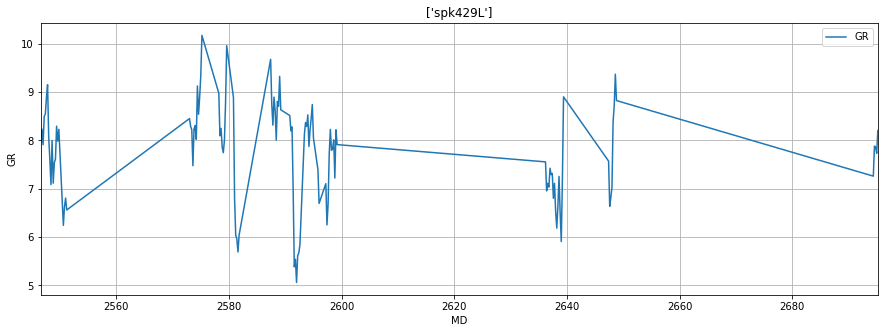

['Скважина - spk432R']
Статистика по всем значениям


MD         BK     Facies         GR   LIT       NKTB  \
count    32.000000  32.000000  32.000000  32.000000  32.0  32.000000   
mean   2639.550000   6.904750   5.000000   9.940281   4.0   4.565813   
std      24.640957   2.186273   3.519531   1.291304   0.0   0.286957   
min    2618.400000   4.542000  -1.000000   8.498000   4.0   3.810950   
25%    2623.300000   5.519750   5.000000   9.012000   4.0   4.427951   
50%    2630.100000   5.965500   7.000000   9.769500   4.0   4.593153   
75%    2643.550000   7.625000   7.000000  10.321500   4.0   4.764933   
max    2683.000000  11.804000   7.000000  14.940000   4.0   5.064987   

               SP  
count   32.000000  
mean   163.043072  
std     10.093007  
min    145.466800  
25%    155.203325  
50%    164.263250  
75%    171.811350  
max    184.422300

Статистика по известным значениям Facies


MD         BK  Facies         GR   LIT       NKTB          SP
count    24.000000  24.000000    24.0  24.000000  24.0  24.000000   24.000000
mean   2625.800000   5.724292     7.0  10.144292   4.0   4.596417  159.683479
std       5.228683   0.662376     0.0   1.389153   0.0   0.245774    9.434088
min    2618.400000   4.542000     7.0   8.548000   4.0   4.076468  145.466800
25%    2620.350000   5.344000     7.0   9.370250   4.0   4.462188  152.312525
50%    2624.900000   5.732000     7.0  10.084500   4.0   4.593153  159.211700
75%    2630.600000   6.043000     7.0  10.372000   4.0   4.764933  165.013350
max    2632.200000   6.978000     7.0  14.940000   4.0   5.064987  184.422300

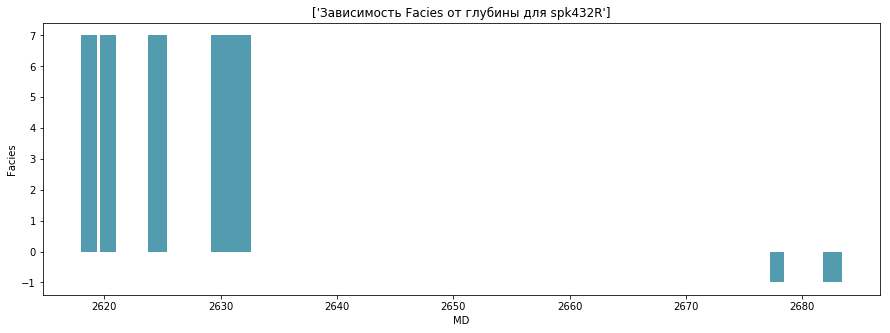

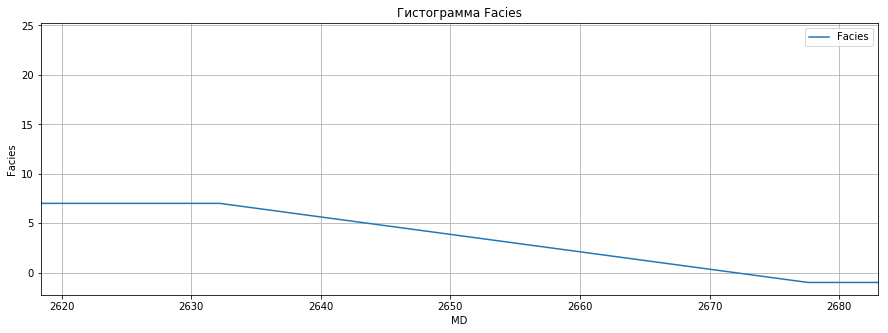

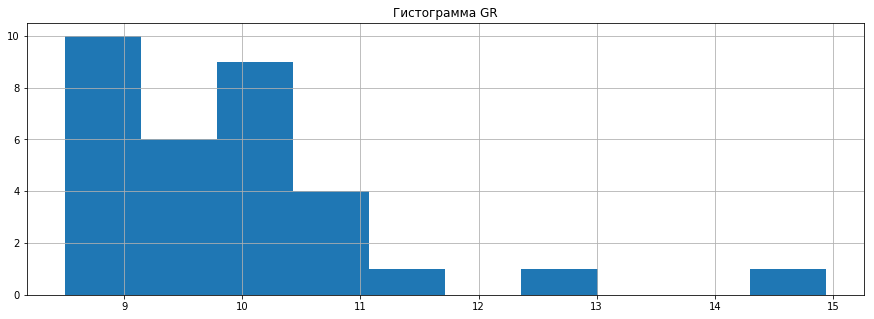

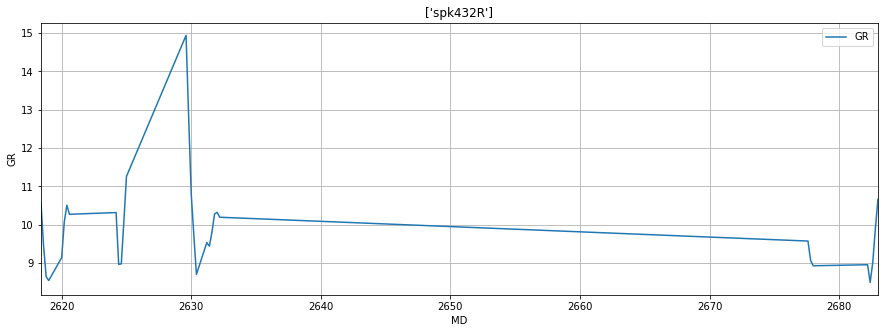

['Скважина - spk967']
Статистика по всем значениям


MD   BK    Facies         GR   LIT       NKTB          SP
count    24.000000  0.0  24.00000  24.000000  24.0  24.000000   24.000000
mean   2932.650000  NaN   2.50000   8.886250   4.0   4.118025  109.749560
std       9.767248  NaN   2.55377   0.582639   0.0   0.220787    5.872991
min    2922.600000  NaN   0.00000   7.860000   4.0   3.732640   97.675080
25%    2925.150000  NaN   0.00000   8.440000   4.0   3.903070  107.291675
50%    2928.500000  NaN   2.50000   8.920000   4.0   4.176930  109.716350
75%    2946.450000  NaN   5.00000   9.407500   4.0   4.289087  114.239650
max    2947.600000  NaN   5.00000   9.790000   4.0   4.475000  116.862400

Статистика по известным значениям Facies


MD   BK    Facies         GR   LIT       NKTB          SP
count    24.000000  0.0  24.00000  24.000000  24.0  24.000000   24.000000
mean   2932.650000  NaN   2.50000   8.886250   4.0   4.118025  109.749560
std       9.767248  NaN   2.55377   0.582639   0.0   0.220787    5.872991
min    2922.600000  NaN   0.00000   7.860000   4.0   3.732640   97.675080
25%    2925.150000  NaN   0.00000   8.440000   4.0   3.903070  107.291675
50%    2928.500000  NaN   2.50000   8.920000   4.0   4.176930  109.716350
75%    2946.450000  NaN   5.00000   9.407500   4.0   4.289087  114.239650
max    2947.600000  NaN   5.00000   9.790000   4.0   4.475000  116.862400

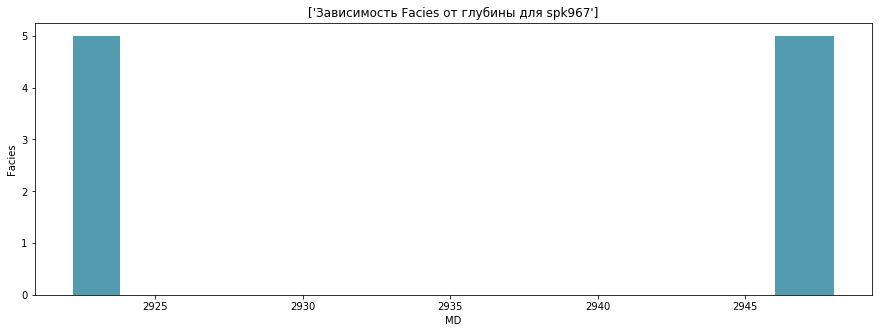

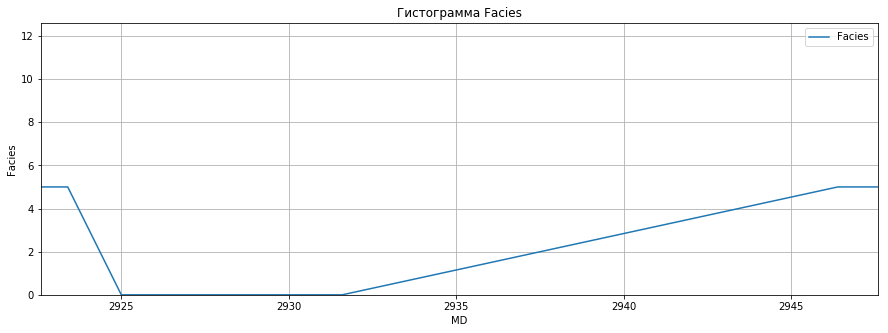

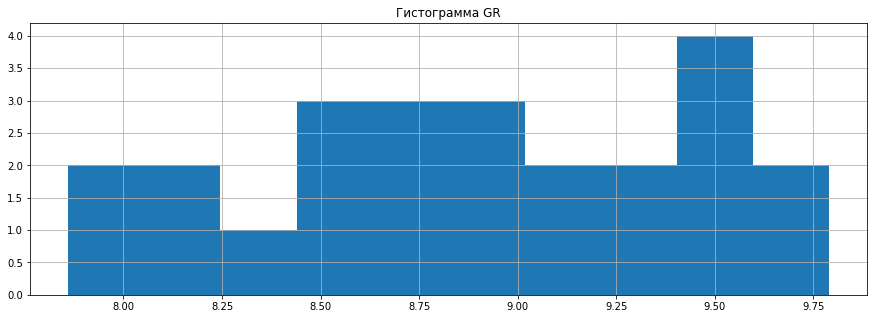

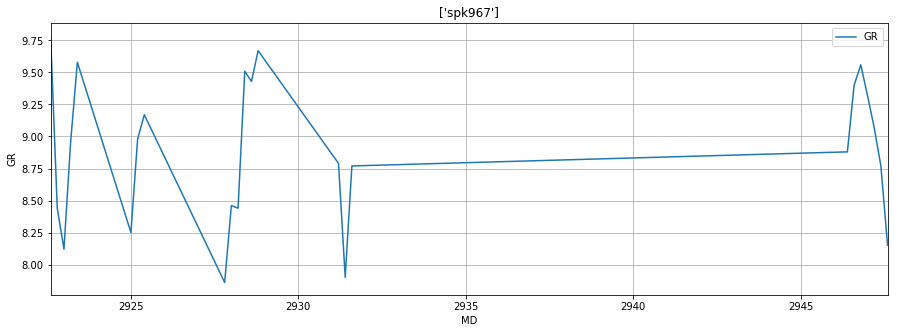

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline


def barplot(x_data, y_data, x_label="", y_label="", title=""):
    _, ax = plt.subplots(figsize=(15,5))
    ax.bar(x_data, y_data, color = '#539caf', align = 'center')
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    
def info_well(well, feature_name):
    well_name = well['wellName'].unique()
    print("Скважина - " + well_name)
    print("Статистика по всем значениям")
    display(well.describe())
    print("Статистика по известным значениям Facies")
    display(well[well['Facies'] != -1].describe())
    barplot(well['MD'], well['Facies'],'MD', 'Facies', 'Зависимость Facies от глубины для ' + well_name)
    plt.show()

    well.plot(x='MD', y=['Facies'], figsize=(15,5), grid=True)
    plt.xlabel('MD')
    plt.ylabel('Facies')
    plt.title(well_name + ' Facies')

    plt.title("Гистограмма Facies")
    plt.show(well['Facies'].hist(figsize=(15,5)))


    hist = well[feature_name].hist(figsize=(15,5))
    plt.title('Гистограмма ' + feature_name)
    plt.show(hist)

    well.plot(x='MD', y=[feature_name], figsize=(15,5), grid=True)
    plt.xlabel('MD')
    plt.ylabel(feature_name)
    plt.title(well_name)
    plt.show()

def info_print(wells, feature_name):
    from IPython.display import clear_output
    for well in wells:
        info_well(well, feature_name)

wells = get_well_dfs(filter_base_df)
info_print(wells, 'GR')

['Скважина - spk1521']
Статистика по всем значениям


MD          BK      Facies          GR    LIT        NKTB  \
count   118.000000  118.000000  118.000000  118.000000  118.0  118.000000   
mean   3042.544068    8.308390    5.618644    9.418390    4.0    4.868172   
std      14.295535    3.611698    3.143082    0.857225    0.0    0.440607   
min    3022.400000    3.830000   -1.000000    7.650000    4.0    3.950053   
25%    3031.050000    5.322500    7.000000    8.715000    4.0    4.598722   
50%    3041.700000    7.665000    7.000000    9.390000    4.0    4.945802   
75%    3048.550000   11.000000    7.000000   10.007500    4.0    5.228440   
max    3073.200000   25.750000    8.000000   12.050000    4.0    5.692705   

               SP  
count  118.000000  
mean   101.717288  
std      5.435483  
min     95.560000  
25%     97.657500  
50%     99.915000  
75%    103.645000  
max    115.480000

Статистика по известным значениям Facies


MD          BK      Facies          GR    LIT        NKTB  \
count   102.000000  102.000000  102.000000  102.000000  102.0  102.000000   
mean   3038.162745    8.583725    6.656863    9.313725    4.0    4.952626   
std       9.642346    3.217025    1.848173    0.836166    0.0    0.383380   
min    3022.400000    3.940000    0.000000    7.650000    4.0    3.950053   
25%    3029.450000    5.475000    7.000000    8.662500    4.0    4.731470   
50%    3040.100000    8.885000    7.000000    9.295000    4.0    4.999006   
75%    3046.150000   11.165000    7.000000    9.915000    4.0    5.249789   
max    3055.800000   20.060000    8.000000   12.050000    4.0    5.692705   

               SP  
count  102.000000  
mean   100.029020  
std      3.563333  
min     95.560000  
25%     97.240000  
50%     99.295000  
75%    101.610000  
max    114.600000

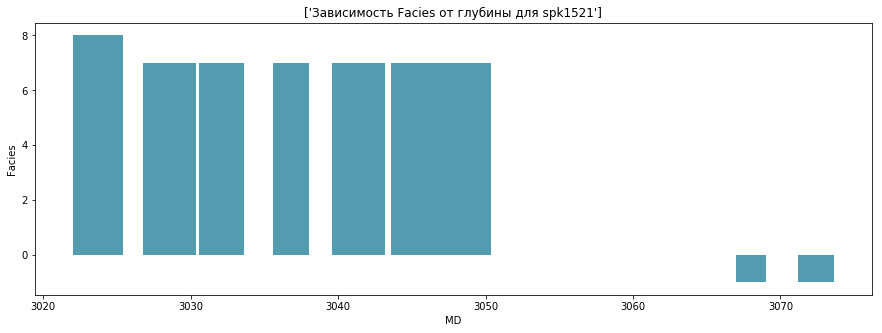

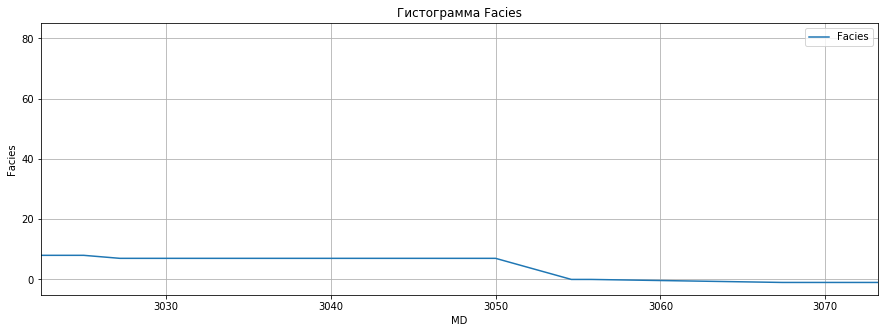

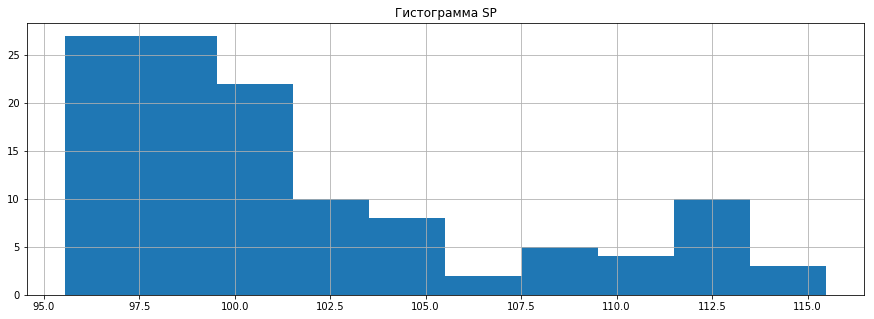

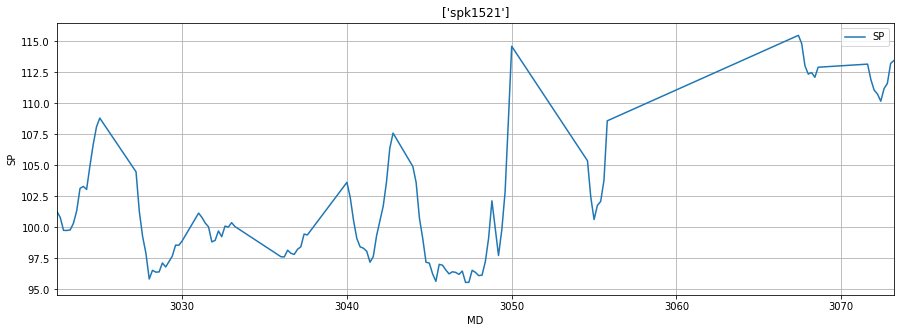

['Скважина - spk1527']
Статистика по всем значениям


MD           BK       Facies           GR     LIT  \
count  1370.000000  1370.000000  1370.000000  1370.000000  1370.0   
mean   2271.314745     6.074825    -0.581752     6.908964     4.0   
std     186.963197     4.236545     1.775851     1.051555     0.0   
min    2004.000000     1.870000    -1.000000     4.450000     4.0   
25%    2150.450000     4.392500    -1.000000     6.090000     4.0   
50%    2219.100000     5.090000    -1.000000     6.790000     4.0   
75%    2398.950000     6.347500    -1.000000     7.557500     4.0   
max    2729.600000    85.950000     8.000000    10.840000     4.0   

              NKTB           SP  
count  1370.000000  1370.000000  
mean      3.373942    69.439015  
std       0.525041    12.899633  
min       1.860000    45.710000  
25%       3.060000    58.870000  
50%       3.270000    68.075000  
75%       3.570000    77.747500  
max       7.930000   106.630000

Статистика по известным значениям Facies


MD         BK     Facies         GR   LIT       NKTB  \
count    86.000000  86.000000  86.000000  86.000000  86.0  86.000000   
mean   2693.890698  15.279419   5.662791   5.716628   4.0   4.323372   
std       7.934891   5.322073   2.949020   0.557983   0.0   0.398210   
min    2682.000000   5.810000   0.000000   4.840000   4.0   3.570000   
25%    2688.050000  10.690000   7.000000   5.380000   4.0   4.125000   
50%    2693.700000  16.140000   7.000000   5.600000   4.0   4.280000   
75%    2698.100000  19.005000   7.000000   5.825000   4.0   4.535000   
max    2713.000000  27.290000   8.000000   8.090000   4.0   5.640000   

              SP  
count  86.000000  
mean   60.384767  
std     6.260759  
min    52.900000  
25%    56.712500  
50%    57.795000  
75%    61.537500  
max    77.910000

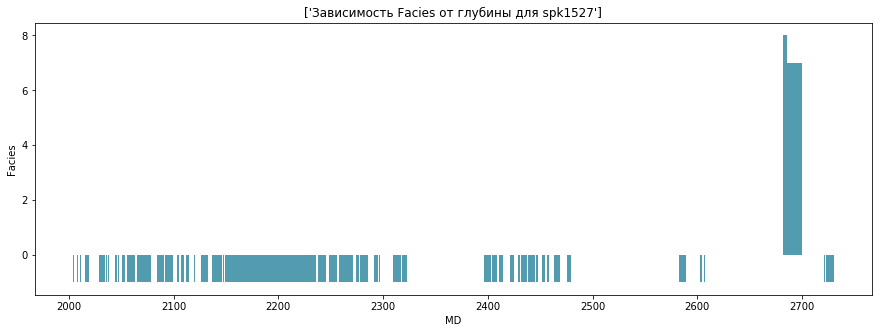

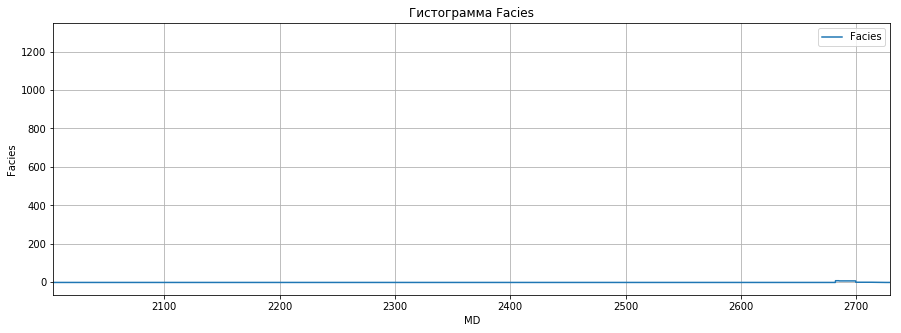

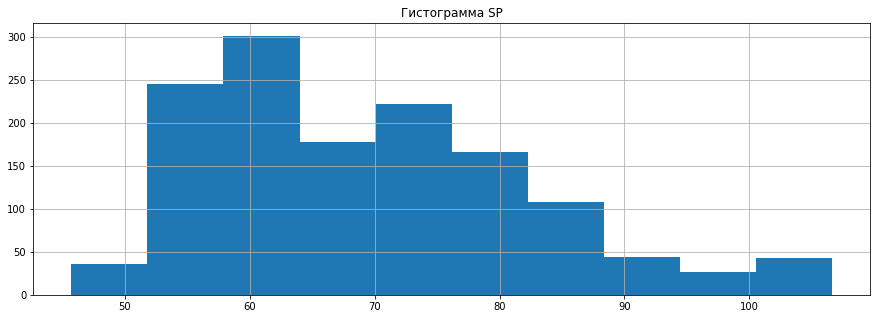

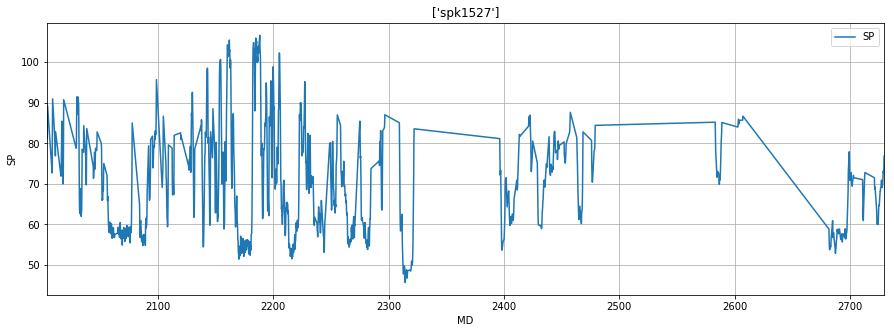

['Скважина - spk1769']
Статистика по всем значениям


MD           BK       Facies           GR     LIT  \
count  1029.000000  1029.000000  1029.000000  1029.000000  1029.0   
mean   2269.674830     8.655423    -0.762877  -177.420641     4.0   
std     209.955859     4.610645     1.057741  1347.748038     0.0   
min    2000.000000     3.270000    -1.000000 -9999.000000     4.0   
25%    2090.200000     6.120000    -1.000000     6.570000     4.0   
50%    2200.600000     7.910000    -1.000000     7.240000     4.0   
75%    2492.200000    10.040000    -1.000000     7.950000     4.0   
max    2662.600000    91.580000     5.000000    10.790000     4.0   

              NKTB           SP  
count  1029.000000  1029.000000  
mean   -181.644985    90.976433  
std    1347.168060    22.405066  
min   -9999.000000    59.550000  
25%       2.620000    69.330000  
50%       2.930000    87.470000  
75%       3.360000   113.560000  
max       6.730000   129.980000

Статистика по известным значениям Facies


MD         BK     Facies         GR   LIT       NKTB  \
count    62.000000  62.000000  62.000000  62.000000  62.0  62.000000   
mean   2595.432258  12.351613   2.935484   6.582581   4.0   3.607258   
std       6.684574   2.898429   2.015277   1.370820   0.0   0.375666   
min    2582.800000   3.750000   1.000000   4.060000   4.0   2.770000   
25%    2592.850000   9.502500   1.000000   5.375000   4.0   3.265000   
50%    2596.900000  13.355000   1.000000   6.455000   4.0   3.665000   
75%    2599.950000  14.167500   5.000000   7.645000   4.0   3.880000   
max    2607.200000  17.190000   5.000000   9.700000   4.0   4.350000   

               SP  
count   62.000000  
mean   101.408710  
std     19.566809  
min     77.010000  
25%     81.100000  
50%    106.485000  
75%    120.082500  
max    128.380000

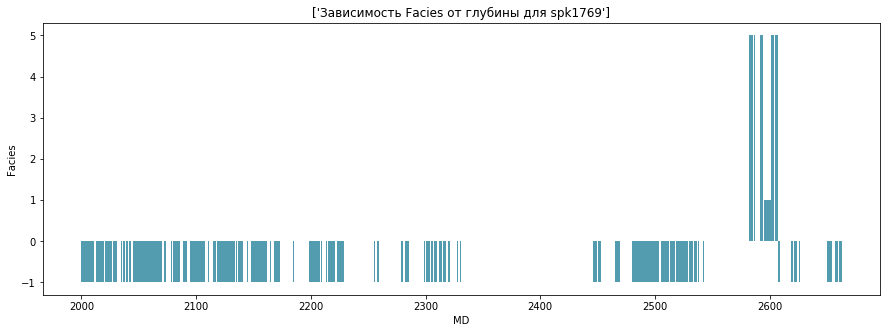

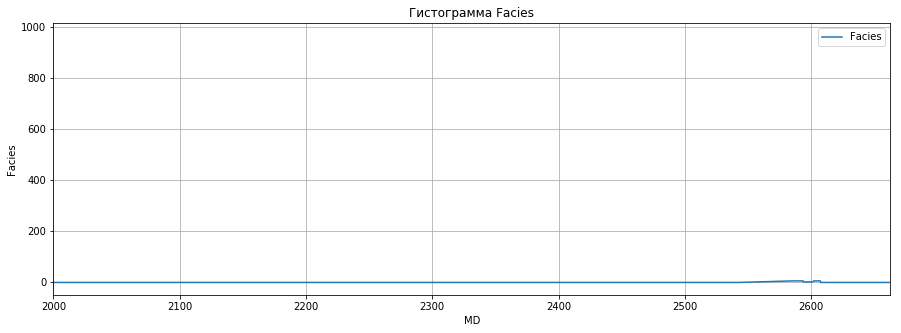

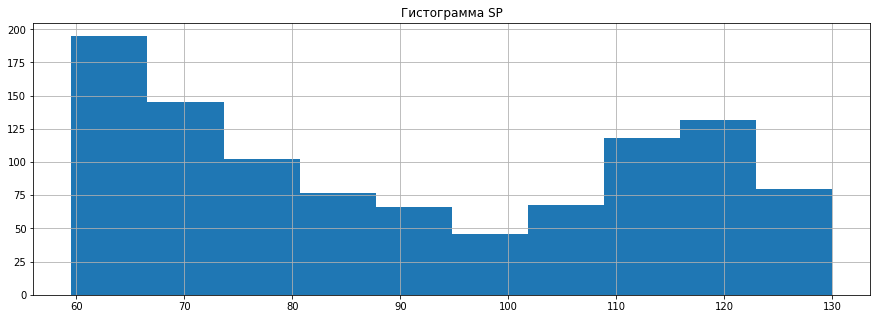

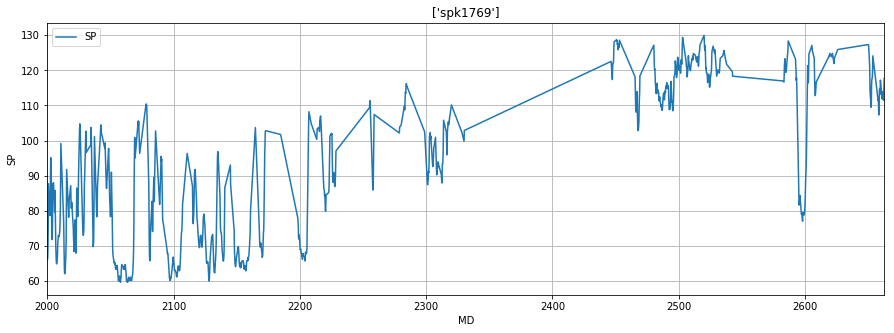

['Скважина - spk400']
Статистика по всем значениям


MD         BK     Facies         GR   LIT       NKTB  \
count    83.000000  83.000000  83.000000  83.000000  83.0  83.000000   
mean   2539.450602  15.361446   6.807229   6.106928   4.0   4.545400   
std       6.526202   2.533413   0.593827   0.446904   0.0   0.228506   
min    2532.700000   9.570000   5.000000   4.780000   4.0   3.856798   
25%    2534.750000  13.590000   7.000000   5.872500   4.0   4.419495   
50%    2539.000000  15.650000   7.000000   6.050000   4.0   4.613760   
75%    2541.050000  17.160000   7.000000   6.510000   4.0   4.720940   
max    2557.400000  20.460000   7.000000   6.950000   4.0   4.881711   

               SP  
count   83.000000  
mean    96.032421  
std      6.004532  
min     87.790760  
25%     90.313530  
50%     94.883330  
75%    101.204800  
max    106.967800

Статистика по известным значениям Facies


MD         BK     Facies         GR   LIT       NKTB  \
count    83.000000  83.000000  83.000000  83.000000  83.0  83.000000   
mean   2539.450602  15.361446   6.807229   6.106928   4.0   4.545400   
std       6.526202   2.533413   0.593827   0.446904   0.0   0.228506   
min    2532.700000   9.570000   5.000000   4.780000   4.0   3.856798   
25%    2534.750000  13.590000   7.000000   5.872500   4.0   4.419495   
50%    2539.000000  15.650000   7.000000   6.050000   4.0   4.613760   
75%    2541.050000  17.160000   7.000000   6.510000   4.0   4.720940   
max    2557.400000  20.460000   7.000000   6.950000   4.0   4.881711   

               SP  
count   83.000000  
mean    96.032421  
std      6.004532  
min     87.790760  
25%     90.313530  
50%     94.883330  
75%    101.204800  
max    106.967800

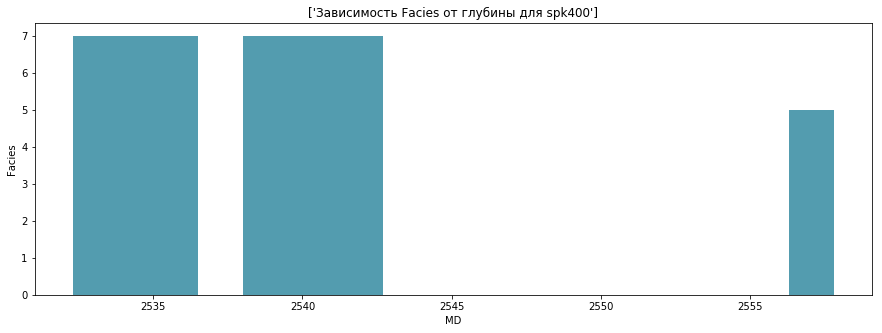

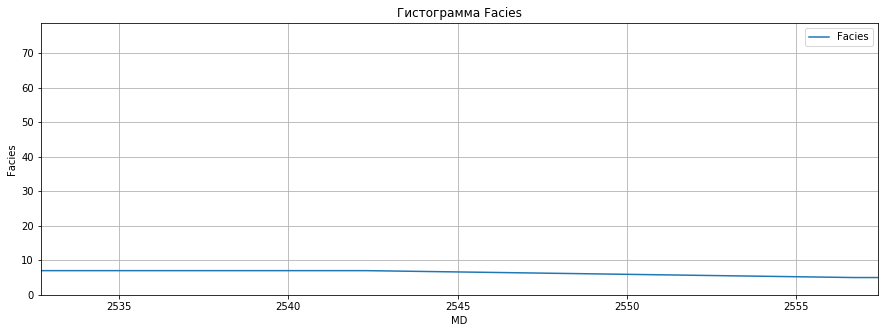

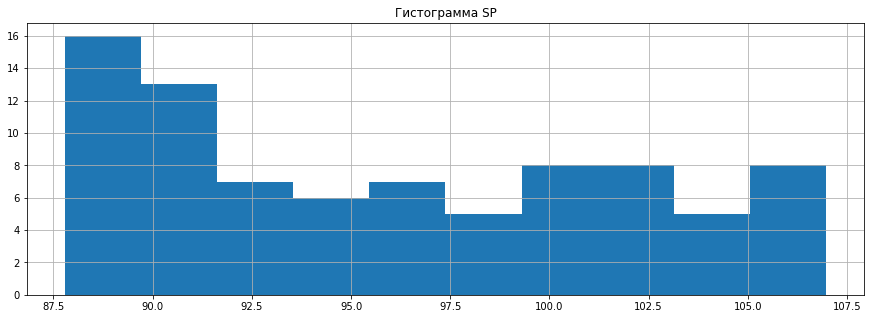

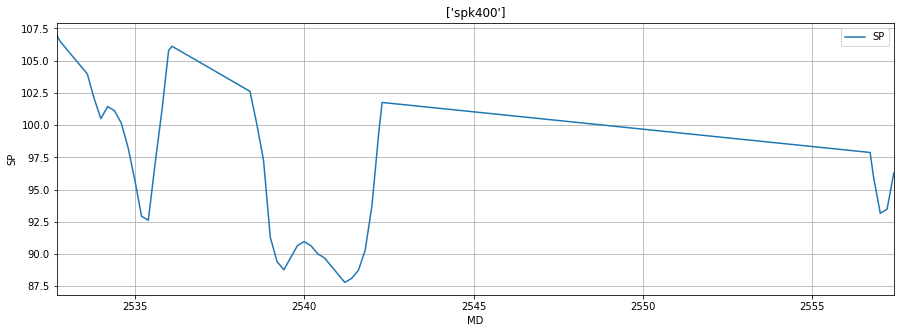

['Скважина - spk403']
Статистика по всем значениям


MD         BK     Facies         GR   LIT       NKTB  \
count    41.000000  41.000000  41.000000  41.000000  41.0  41.000000   
mean   2601.804878  11.536585   0.317073   6.087073   4.0   4.393116   
std      39.376808   2.270105   3.220551   0.536811   0.0   0.203872   
min    2528.400000   7.700000  -1.000000   5.040000   4.0   4.113792   
25%    2569.600000  10.200000  -1.000000   5.750000   4.0   4.210251   
50%    2628.400000  11.500000  -1.000000   6.200000   4.0   4.385631   
75%    2630.400000  13.100000  -1.000000   6.470000   4.0   4.499627   
max    2632.400000  17.300000   8.000000   7.500000   4.0   4.850386   

              SP  
count  41.000000  
mean   54.167940  
std     3.102853  
min    48.496480  
25%    51.398640  
50%    54.296090  
75%    56.958450  
max    59.175730

Статистика по известным значениям Facies


MD         BK  Facies        GR  LIT      NKTB         SP
count     6.000000   6.000000     6.0  6.000000  6.0  6.000000   6.000000
mean   2528.900000  13.500000     8.0  5.765000  4.0  4.704236  57.379818
std       0.374166   3.470447     0.0  0.407222  0.0  0.137051   0.641772
min    2528.400000   7.700000     8.0  5.230000  4.0  4.499627  56.757100
25%    2528.650000  12.300000     8.0  5.490000  4.0  4.622393  56.876058
50%    2528.900000  13.850000     8.0  5.755000  4.0  4.718851  57.205245
75%    2529.150000  15.850000     8.0  6.042500  4.0  4.815310  57.810365
max    2529.400000  17.300000     8.0  6.310000  4.0  4.850386  58.332920

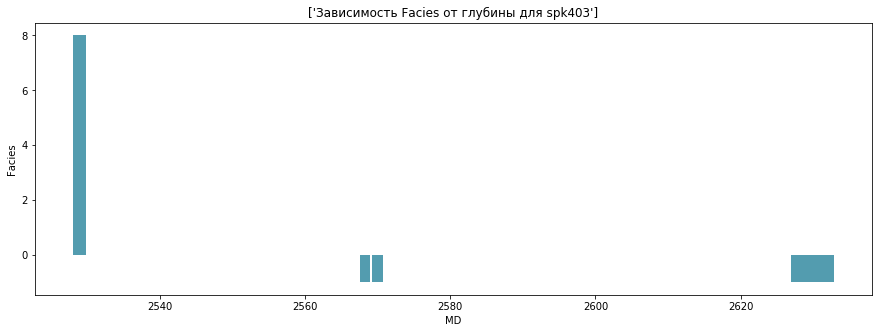

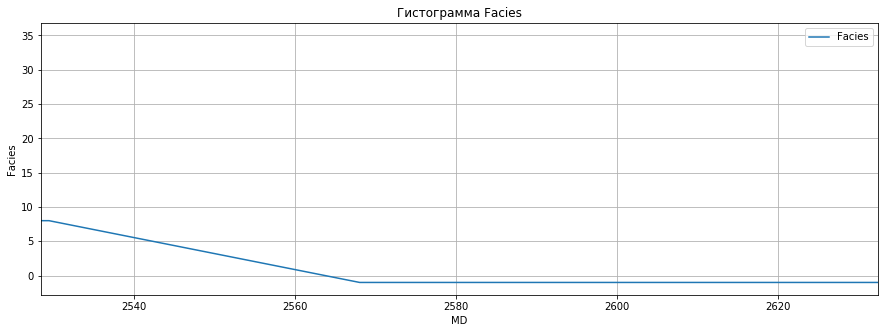

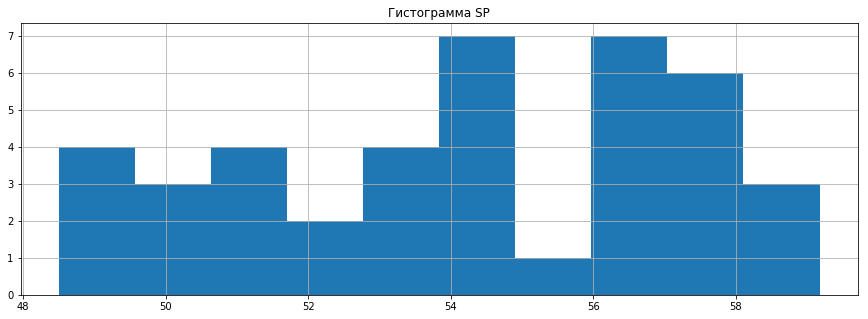

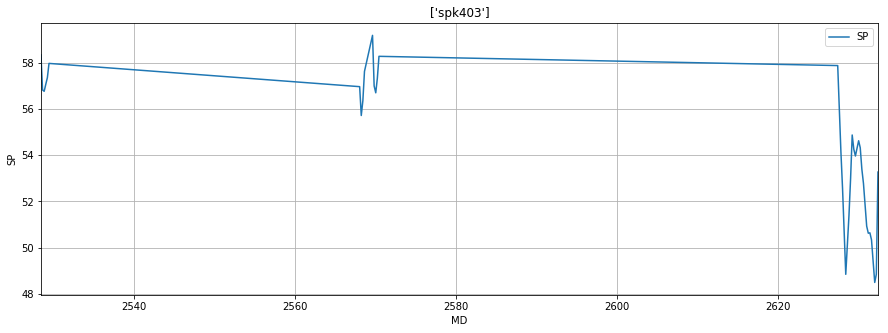

['Скважина - spk405R']
Статистика по всем значениям


MD         BK     Facies         GR   LIT      NKTB  \
count    30.000000  30.000000  30.000000  30.000000  30.0  30.00000   
mean   2525.813333  10.596667   9.066667  10.263333   4.0   4.39325   
std      12.749354   3.117745   4.517654   0.633264   0.0   0.21563   
min    2507.000000   6.500000  -1.000000   9.000000   4.0   3.86500   
25%    2509.450000   8.600000   5.000000   9.700000   4.0   4.32250   
50%    2533.900000   9.000000  12.000000  10.400000   4.0   4.43500   
75%    2535.350000  12.275000  12.000000  10.700000   4.0   4.54750   
max    2536.800000  19.300000  12.000000  11.900000   4.0   4.72000   

               SP  
count   30.000000  
mean   115.356200  
std      5.401736  
min    109.355900  
25%    110.640650  
50%    113.378450  
75%    118.781100  
max    125.184400

Статистика по известным значениям Facies


MD         BK     Facies         GR   LIT       NKTB  \
count    27.000000  27.000000  27.000000  27.000000  27.0  27.000000   
mean   2527.881481  10.711111  10.185185  10.177778   4.0   4.376944   
std      11.699607   3.173367   3.126033   0.598931   0.0   0.220970   
min    2507.600000   8.000000   5.000000   9.000000   4.0   3.865000   
25%    2520.700000   8.600000   8.500000   9.700000   4.0   4.266250   
50%    2534.200000   9.000000  12.000000  10.400000   4.0   4.405000   
75%    2535.500000  12.450000  12.000000  10.400000   4.0   4.547500   
max    2536.800000  19.300000  12.000000  11.900000   4.0   4.720000   

               SP  
count   27.000000  
mean   115.540007  
std      5.665165  
min    109.355900  
25%    110.549450  
50%    113.388300  
75%    121.033600  
max    125.184400

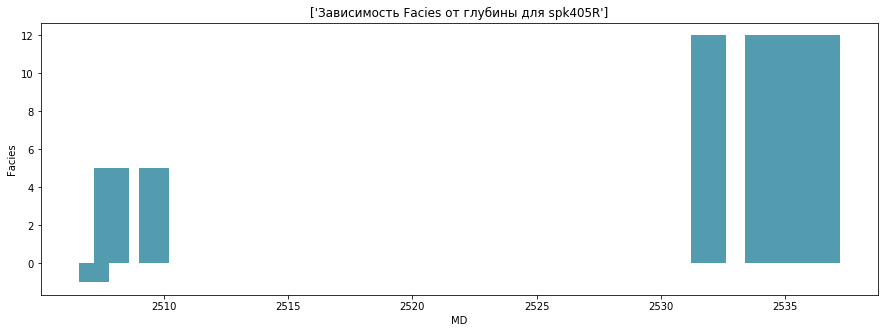

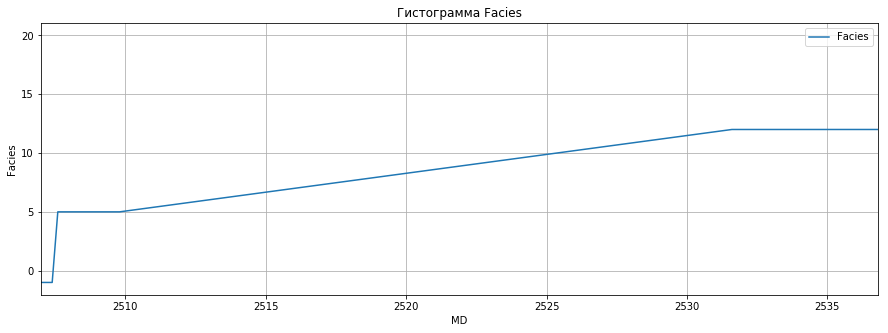

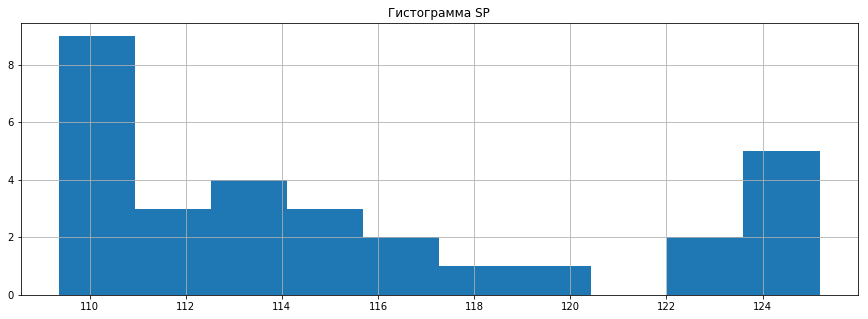

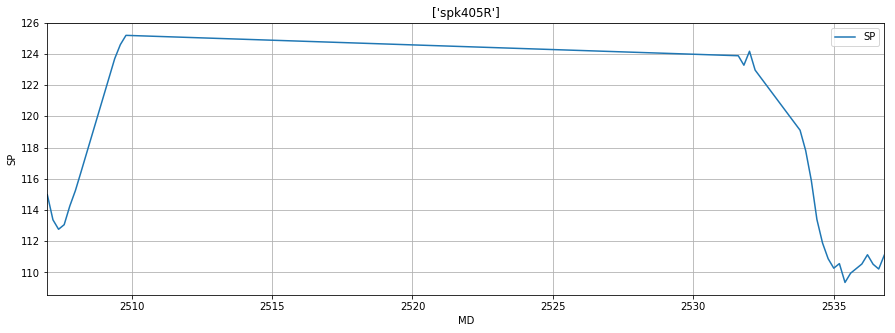

['Скважина - spk406R']
Статистика по всем значениям


MD         BK  Facies         GR   LIT       NKTB         SP
count    18.000000  18.000000    18.0  18.000000  18.0  18.000000  18.000000
mean   2604.500000   7.283333    -1.0   8.133333   4.0   5.671402  68.729911
std       1.067708   0.719681     0.0   0.481419   0.0   0.451920   0.968550
min    2602.800000   6.250000    -1.0   7.400000   4.0   4.622116  67.585110
25%    2603.650000   6.662500    -1.0   7.800000   4.0   5.511493  68.248355
50%    2604.500000   7.150000    -1.0   8.200000   4.0   5.721710  68.402550
75%    2605.350000   7.987500    -1.0   8.550000   4.0   6.020864  68.989323
max    2606.200000   8.300000    -1.0   9.000000   4.0   6.271506  71.420490

Статистика по известным значениям Facies


MD   BK  Facies   GR  LIT  NKTB   SP
count  0.0  0.0     0.0  0.0  0.0   0.0  0.0
mean   NaN  NaN     NaN  NaN  NaN   NaN  NaN
std    NaN  NaN     NaN  NaN  NaN   NaN  NaN
min    NaN  NaN     NaN  NaN  NaN   NaN  NaN
25%    NaN  NaN     NaN  NaN  NaN   NaN  NaN
50%    NaN  NaN     NaN  NaN  NaN   NaN  NaN
75%    NaN  NaN     NaN  NaN  NaN   NaN  NaN
max    NaN  NaN     NaN  NaN  NaN   NaN  NaN

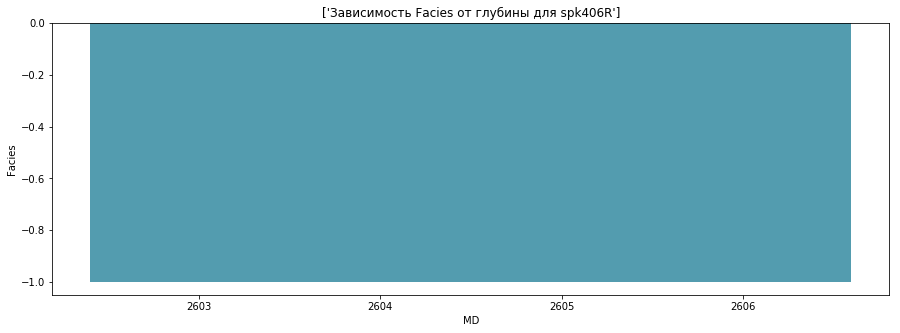

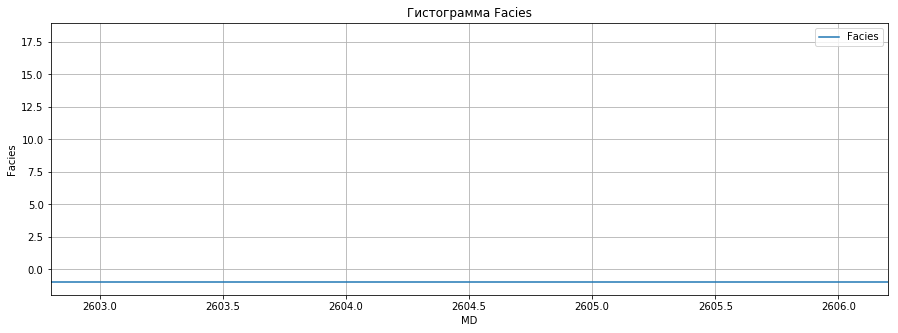

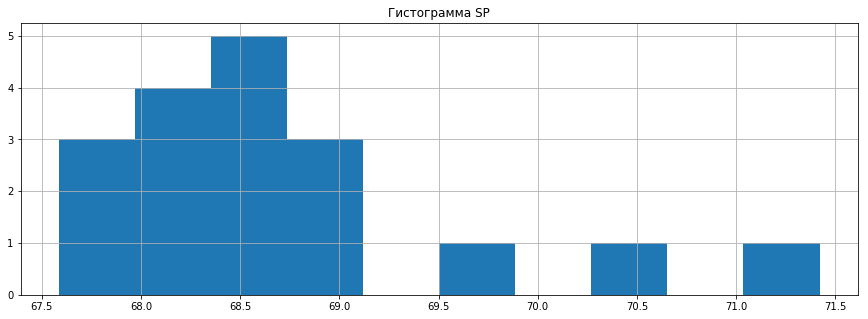

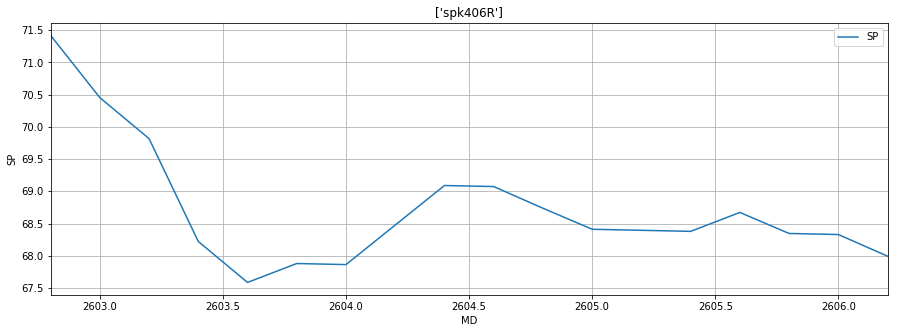

['Скважина - spk409R']
Статистика по всем значениям


MD         BK     Facies         GR   LIT       NKTB  \
count    32.000000  32.000000  32.000000  32.000000  32.0  32.000000   
mean   2569.312500   8.693750   3.468750   4.312500   4.0   4.042330   
std      26.346228   1.078511   3.877016   1.147606   0.0   0.464202   
min    2548.000000   7.200000  -1.000000   2.520000   4.0   2.900339   
25%    2550.350000   7.900000   1.000000   3.500000   4.0   3.840325   
50%    2564.300000   8.300000   1.000000   4.360000   4.0   4.118154   
75%    2565.850000   9.800000   8.000000   5.050000   4.0   4.361254   
max    2621.800000  11.200000   8.000000   6.920000   4.0   4.641399   

              SP  
count  32.000000  
mean   71.042033  
std    11.488844  
min    49.395160  
25%    64.170160  
50%    72.645155  
75%    81.495160  
max    86.095150

Статистика по известным значениям Facies


MD         BK     Facies         GR   LIT       NKTB  \
count    26.000000  26.000000  26.000000  26.000000  26.0  26.000000   
mean   2557.315385   8.776923   4.500000   4.501538   4.0   4.195092   
std       7.896161   1.099930   3.569314   1.113710   0.0   0.274550   
min    2548.000000   7.600000   1.000000   2.560000   4.0   3.733825   
25%    2550.050000   7.900000   1.000000   3.700000   4.0   3.997762   
50%    2557.500000   8.300000   4.500000   4.600000   4.0   4.169090   
75%    2564.950000  10.000000   8.000000   5.110000   4.0   4.465440   
max    2566.200000  11.200000   8.000000   6.920000   4.0   4.641399   

              SP  
count  26.000000  
mean   69.729773  
std    12.275925  
min    49.395160  
25%    59.520160  
50%    72.195160  
75%    81.345160  
max    86.095150

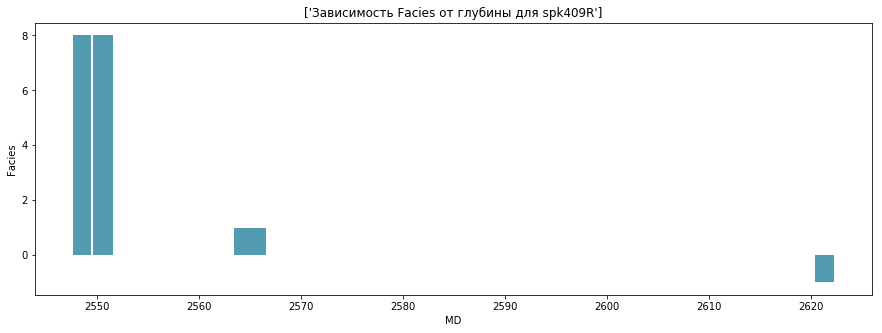

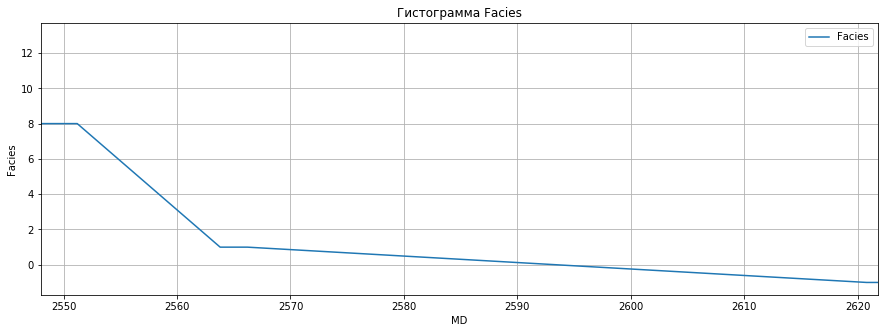

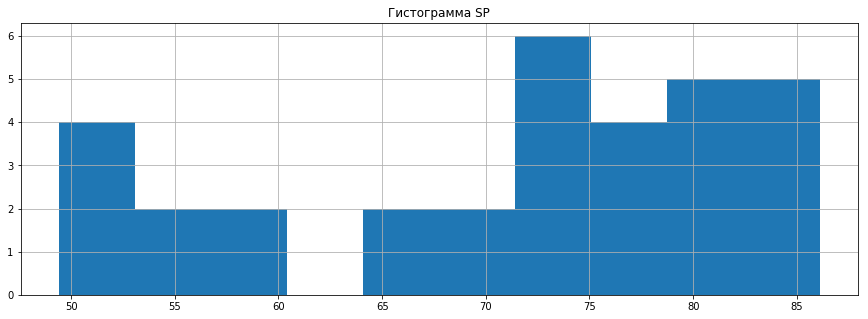

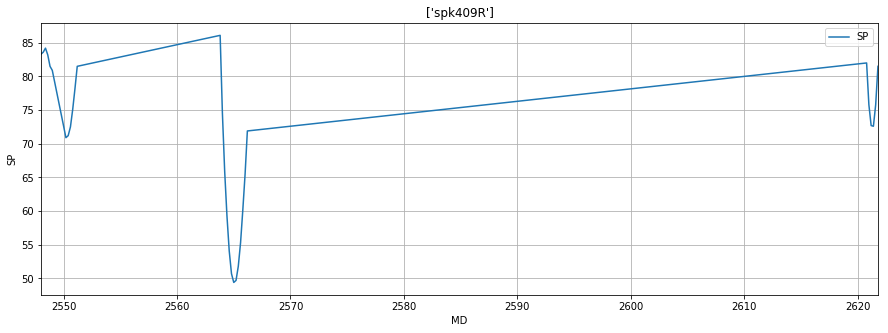

['Скважина - spk420R']
Статистика по всем значениям


MD         BK     Facies         GR   LIT       NKTB         SP
count    64.00000  64.000000  64.000000  64.000000  64.0  64.000000  64.000000
mean   2570.62500   9.368047   2.984375   7.344844   4.0   4.590745  93.475872
std      12.46687   2.751482   2.814318   0.998656   0.0   0.417709   2.654858
min    2550.60000   5.740000  -1.000000   5.670000   4.0   3.891901  89.184360
25%    2561.75000   7.580000   0.000000   6.655000   4.0   4.278536  91.653103
50%    2573.30000   8.800000   3.000000   7.255000   4.0   4.549182  93.150395
75%    2582.85000  10.810000   3.000000   7.840000   4.0   4.786962  94.717318
max    2589.60000  20.430000   8.000000   9.890000   4.0   5.662693  99.437400

Статистика по известным значениям Facies


MD         BK     Facies         GR   LIT       NKTB  \
count    60.000000  60.000000  60.000000  60.000000  60.0  60.000000   
mean   2569.380000   9.563250   3.250000   7.308000   4.0   4.620065   
std      11.863215   2.723315   2.703576   1.010272   0.0   0.414547   
min    2550.600000   5.740000   0.000000   5.670000   4.0   3.891901   
25%    2561.550000   7.916250   2.250000   6.555000   4.0   4.388728   
50%    2572.900000   8.945000   3.000000   7.205000   4.0   4.583979   
75%    2577.450000  10.990000   3.000000   7.752500   4.0   4.829492   
max    2587.600000  20.430000   8.000000   9.890000   4.0   5.662693   

              SP  
count  60.000000  
mean   93.559888  
std     2.650247  
min    89.184360  
25%    91.895093  
50%    93.261090  
75%    94.717318  
max    99.437400

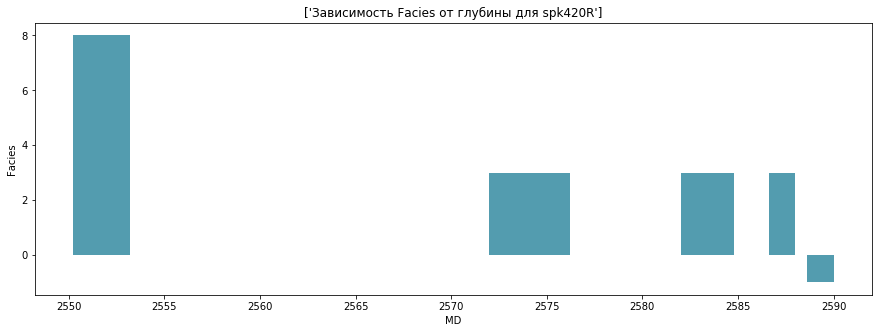

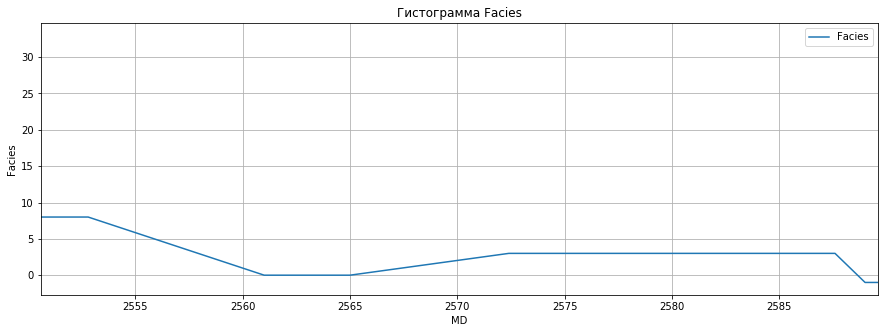

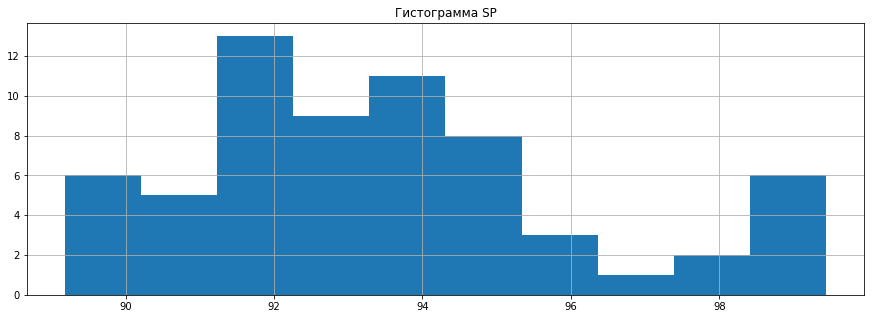

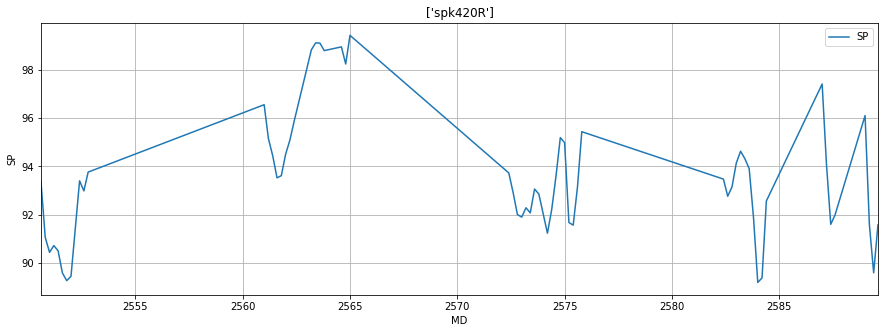

['Скважина - spk424R']
Статистика по всем значениям


MD         BK     Facies         GR   LIT       NKTB  \
count    27.000000  27.000000  27.000000  27.000000  27.0  27.000000   
mean   2556.429630  15.295519   7.481481   7.665519   4.0   4.970876   
std      11.778429   3.863267   4.273085   0.885087   0.0   0.401244   
min    2542.400000   9.130000  -1.000000   6.352000   4.0   4.185875   
25%    2545.500000  12.095500   7.000000   7.089500   4.0   4.736035   
50%    2548.200000  14.951000   7.000000   7.499000   4.0   4.889658   
75%    2568.700000  17.801500  12.000000   8.087500   4.0   5.283699   
max    2570.000000  22.256001  12.000000   9.579000   4.0   5.632817   

               SP  
count   27.000000  
mean   158.989167  
std      5.354604  
min    144.490300  
25%    155.454550  
50%    159.957200  
75%    162.837100  
max    165.559800

Статистика по известным значениям Facies


MD         BK     Facies         GR   LIT       NKTB  \
count    23.000000  23.000000  23.000000  23.000000  23.0  23.000000   
mean   2554.713043  14.461087   8.956522   7.832304   4.0   4.919389   
std      11.964618   3.453229   2.495054   0.842555   0.0   0.407166   
min    2542.400000   9.130000   7.000000   6.494000   4.0   4.185875   
25%    2545.300000  12.064000   7.000000   7.274500   4.0   4.692222   
50%    2547.000000  13.780000   7.000000   7.684000   4.0   4.855273   
75%    2568.900000  17.413500  12.000000   8.325500   4.0   5.256801   
max    2570.000000  21.202000  12.000000   9.579000   4.0   5.632817   

              SP  
count   23.00000  
mean   159.93167  
std      3.96164  
min    153.18820  
25%    156.79010  
50%    160.84630  
75%    162.83710  
max    165.48230

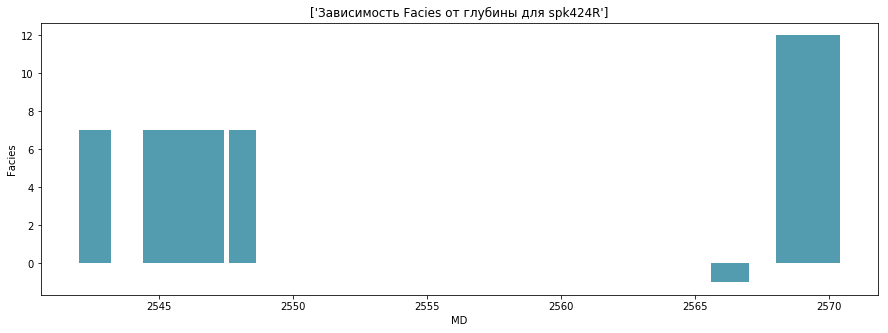

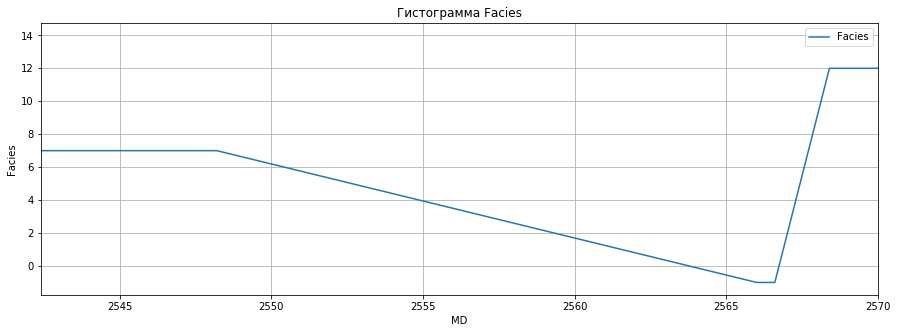

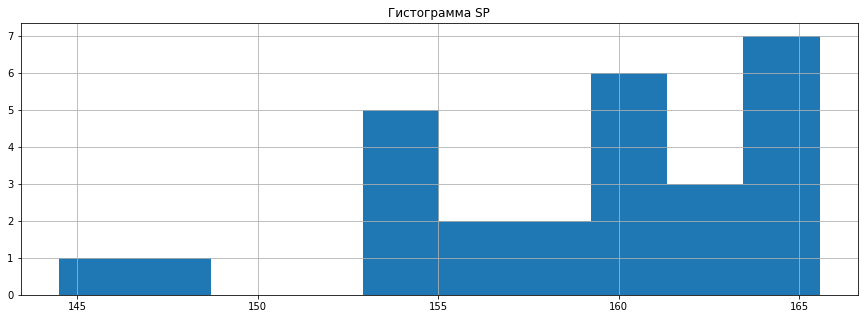

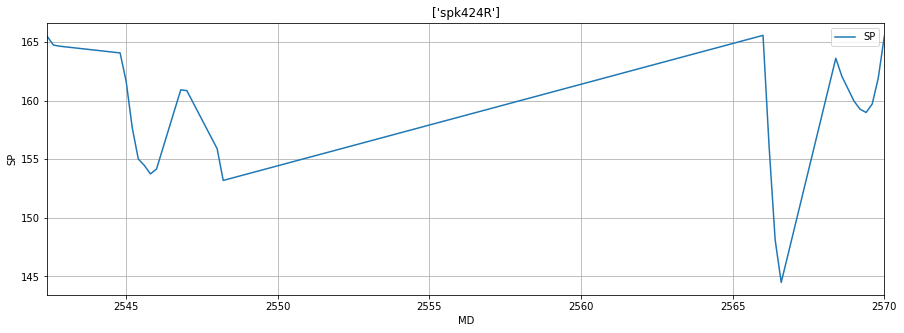

['Скважина - spk426R']
Статистика по всем значениям


MD         BK  Facies         GR   LIT       NKTB         SP
count    21.000000  21.000000    21.0  21.000000  21.0  21.000000  21.000000
mean   2573.514286   8.932905     1.0   5.910571   4.0   4.898745  65.817854
std       1.390786   2.270481     0.0   1.059464   0.0   0.256724  11.372783
min    2571.400000   4.881000     1.0   4.927000   4.0   4.287728  53.691840
25%    2572.400000   7.925000     1.0   5.413000   4.0   4.848731  56.524490
50%    2573.400000   9.561000     1.0   5.634000   4.0   5.001560  63.040700
75%    2574.800000  10.552000     1.0   5.831000   4.0   5.051874  72.057400
max    2575.800000  12.259000     1.0   9.147000   4.0   5.228602  91.545270

Статистика по известным значениям Facies


MD         BK  Facies         GR   LIT       NKTB         SP
count    21.000000  21.000000    21.0  21.000000  21.0  21.000000  21.000000
mean   2573.514286   8.932905     1.0   5.910571   4.0   4.898745  65.817854
std       1.390786   2.270481     0.0   1.059464   0.0   0.256724  11.372783
min    2571.400000   4.881000     1.0   4.927000   4.0   4.287728  53.691840
25%    2572.400000   7.925000     1.0   5.413000   4.0   4.848731  56.524490
50%    2573.400000   9.561000     1.0   5.634000   4.0   5.001560  63.040700
75%    2574.800000  10.552000     1.0   5.831000   4.0   5.051874  72.057400
max    2575.800000  12.259000     1.0   9.147000   4.0   5.228602  91.545270

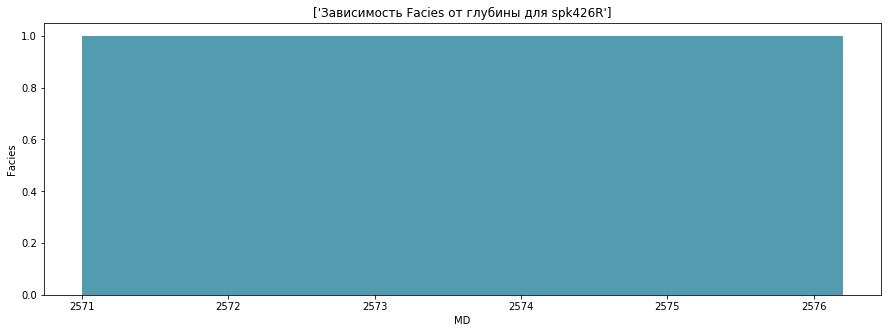

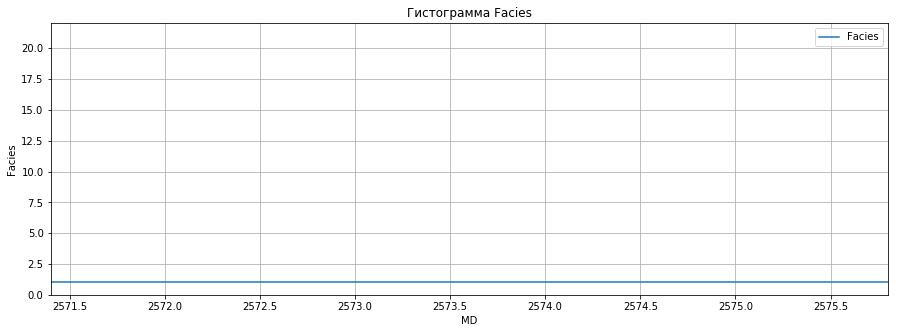

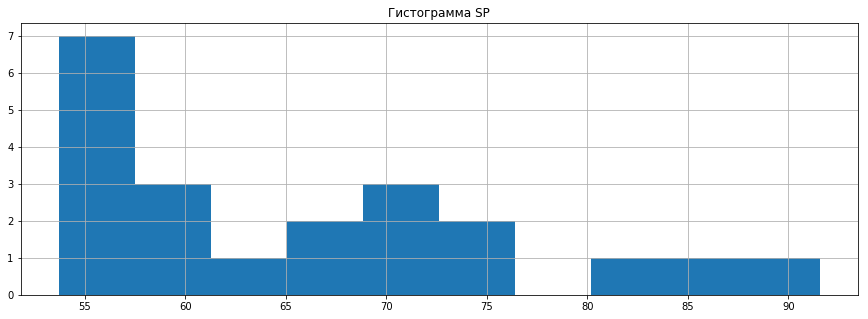

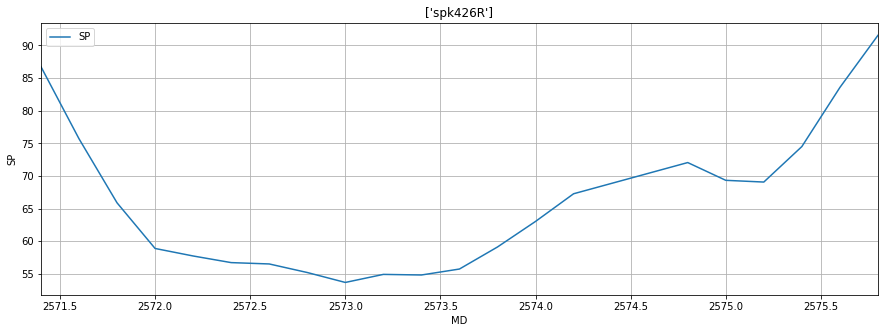

['Скважина - spk427R']
Статистика по всем значениям


MD         BK     Facies         GR   LIT       NKTB   SP
count    57.000000  57.000000  57.000000  57.000000  57.0  57.000000  0.0
mean   2573.722807   6.841912   3.789474   8.305263   4.0   4.446028  NaN
std      12.809971   6.045535   3.754696   1.001324   0.0   0.517792  NaN
min    2559.000000   4.181000   0.000000   6.200000   4.0   3.672621  NaN
25%    2562.200000   4.997000   0.000000   7.600000   4.0   3.965555  NaN
50%    2573.600000   5.640000   5.000000   8.300000   4.0   4.337534  NaN
75%    2579.600000   6.932000   8.000000   8.800000   4.0   4.983848  NaN
max    2600.800000  49.738000   8.000000  10.600000   4.0   5.537167  NaN

Статистика по известным значениям Facies


MD         BK     Facies         GR   LIT       NKTB   SP
count    57.000000  57.000000  57.000000  57.000000  57.0  57.000000  0.0
mean   2573.722807   6.841912   3.789474   8.305263   4.0   4.446028  NaN
std      12.809971   6.045535   3.754696   1.001324   0.0   0.517792  NaN
min    2559.000000   4.181000   0.000000   6.200000   4.0   3.672621  NaN
25%    2562.200000   4.997000   0.000000   7.600000   4.0   3.965555  NaN
50%    2573.600000   5.640000   5.000000   8.300000   4.0   4.337534  NaN
75%    2579.600000   6.932000   8.000000   8.800000   4.0   4.983848  NaN
max    2600.800000  49.738000   8.000000  10.600000   4.0   5.537167  NaN

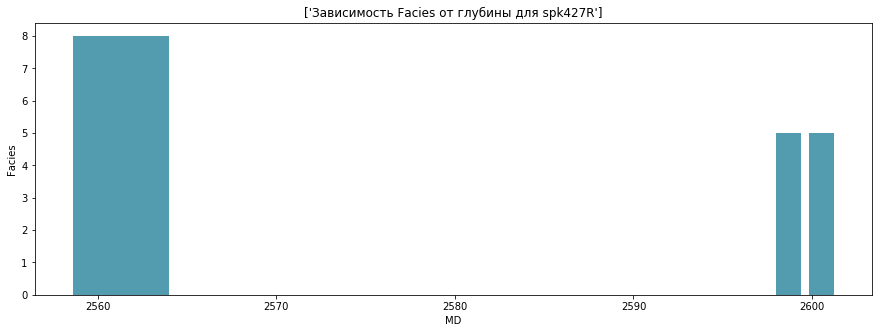

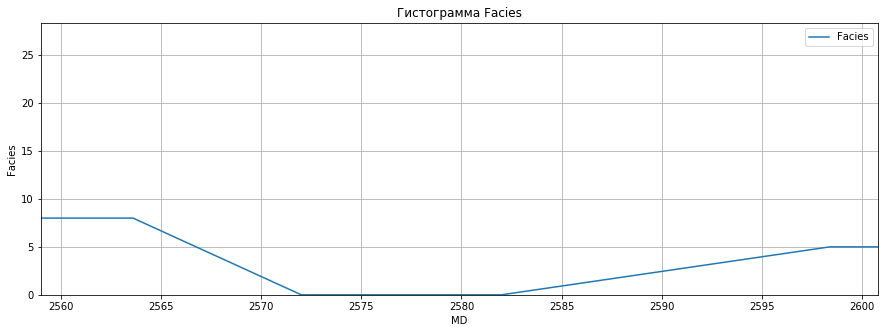

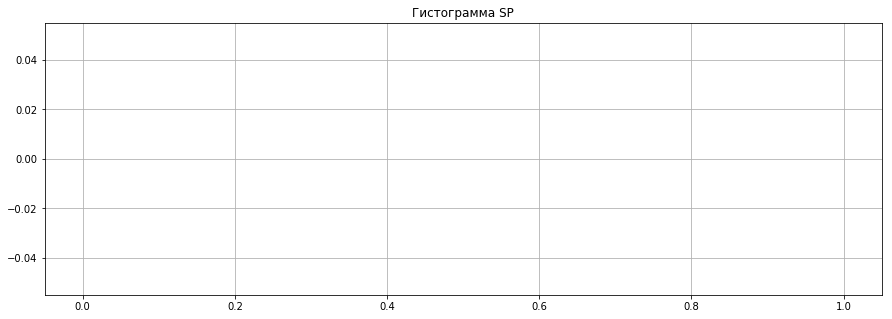

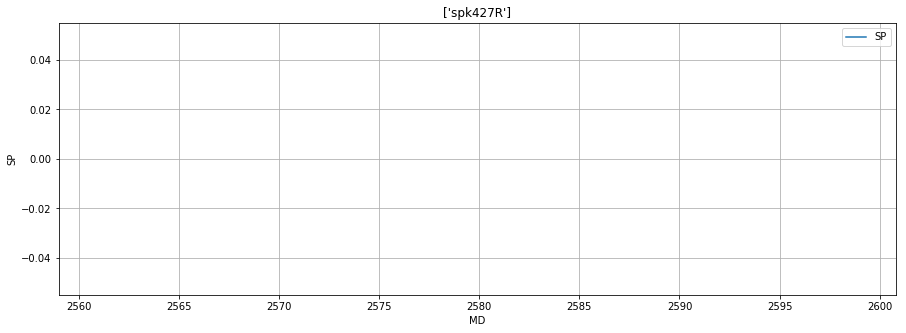

['Скважина - spk428R']
Статистика по всем значениям


MD         BK     Facies         GR   LIT       NKTB  \
count    76.000000  76.000000  76.000000  76.000000  76.0  76.000000   
mean   2620.747368   9.521447   1.460526   7.675789   4.0   4.773395   
std      30.253125   2.276282   3.575624   1.043391   0.0   0.509966   
min    2581.600000   5.890000  -1.000000   5.730000   4.0   3.749000   
25%    2594.950000   7.557500  -1.000000   6.915000   4.0   4.412250   
50%    2608.300000   8.920000  -1.000000   7.875000   4.0   4.869000   
75%    2650.650000  11.205000   7.000000   8.352500   4.0   5.194500   
max    2672.800000  16.330000   7.000000  10.500000   4.0   5.877000   

               SP  
count   76.000000  
mean   125.578610  
std     18.313174  
min     84.717560  
25%    114.333725  
50%    131.440000  
75%    140.932350  
max    146.799600

Статистика по известным значениям Facies


MD         BK     Facies         GR   LIT       NKTB  \
count    33.000000  33.000000  33.000000  33.000000  33.0  33.000000   
mean   2599.018182   8.475152   4.666667   8.300000   4.0   5.009212   
std      11.871222   2.263787   3.350995   0.530053   0.0   0.419849   
min    2581.600000   5.890000   0.000000   7.210000   4.0   3.938000   
25%    2583.200000   7.300000   0.000000   7.980000   4.0   4.736000   
50%    2605.800000   7.730000   7.000000   8.210000   4.0   5.142000   
75%    2608.200000   8.770000   7.000000   8.680000   4.0   5.282000   
max    2609.800000  16.330000   7.000000   9.430000   4.0   5.877000   

               SP  
count   33.000000  
mean   140.625779  
std      3.981676  
min    132.504900  
25%    137.745900  
50%    141.727400  
75%    143.681900  
max    146.799600

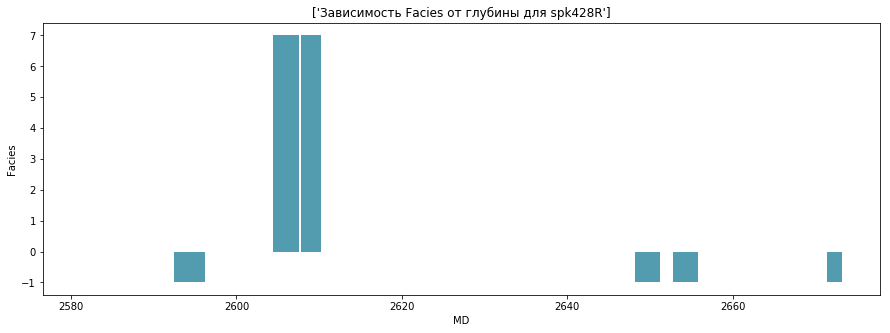

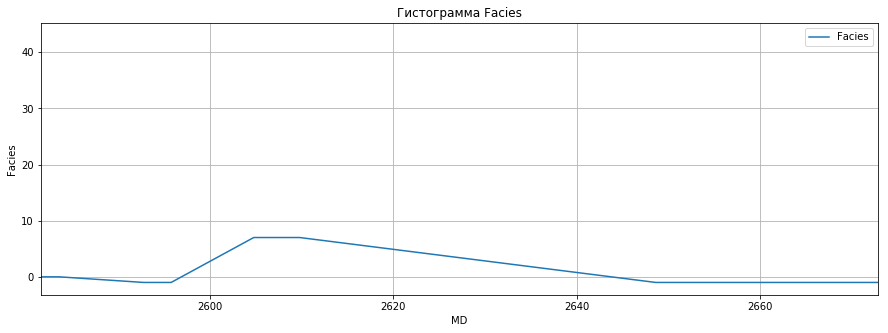

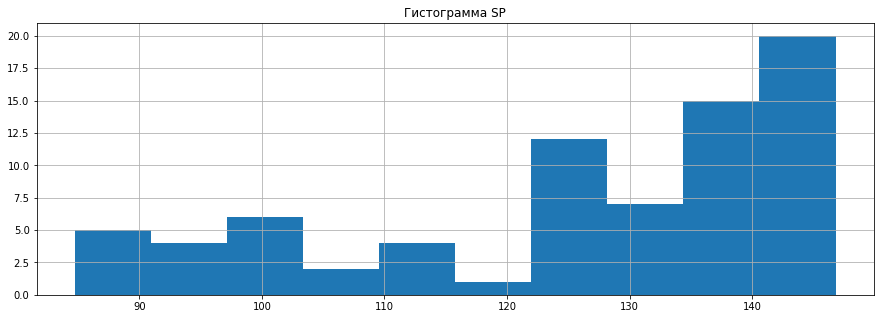

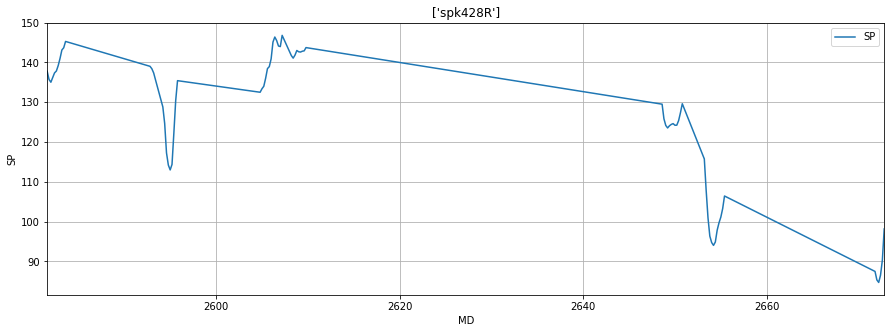

['Скважина - spk429L']
Статистика по всем значениям


MD          BK      Facies          GR    LIT        NKTB  \
count   119.000000  119.000000  119.000000  119.000000  119.0  119.000000   
mean   2596.238655   10.321950    2.831933    7.726471    4.0    4.906121   
std      36.534741    4.091639    4.013366    1.036150    0.0    0.418231   
min    2546.600000    4.683000   -1.000000    5.060000    4.0    4.090785   
25%    2574.700000    7.341000   -1.000000    7.058500    4.0    4.653757   
50%    2591.200000    9.815001   -1.000000    7.911000    4.0    4.844265   
75%    2617.700000   11.881500    7.000000    8.416500    4.0    5.205089   
max    2695.200000   28.359000    7.000000   10.171000    4.0    6.192547   

                SP  
count   119.000000  
mean   -336.612915  
std    2032.127138  
min   -9999.000000  
25%      85.221820  
50%      87.778780  
75%      90.039095  
max      98.553790

Статистика по известным значениям Facies


MD         BK  Facies         GR   LIT       NKTB         SP
count    57.000000  57.000000    57.0  57.000000  57.0  57.000000  57.000000
mean   2568.670175   9.948456     7.0   8.083895   4.0   4.909576  87.926158
std      16.044514   4.945442     0.0   0.996794   0.0   0.508386   3.796703
min    2546.600000   4.683000     7.0   5.690000   4.0   4.161098  77.529530
25%    2549.400000   7.055000     7.0   7.612000   4.0   4.457073  86.565850
50%    2574.400000   8.588000     7.0   8.232000   4.0   4.797707  88.281950
75%    2581.000000  11.088000     7.0   8.753000   4.0   5.286091  89.664090
max    2589.200000  28.359000     7.0  10.171000   4.0   6.192547  98.553790

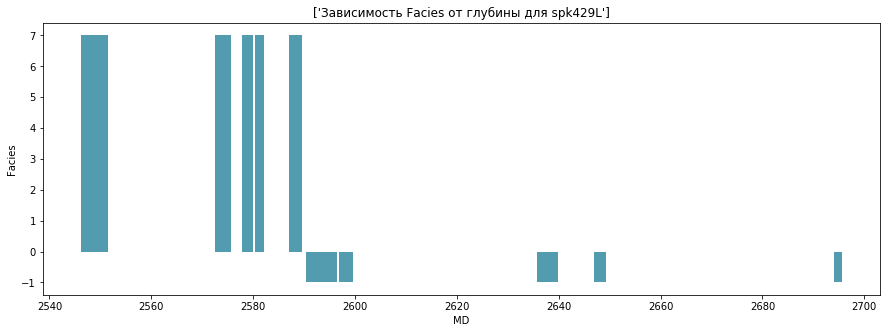

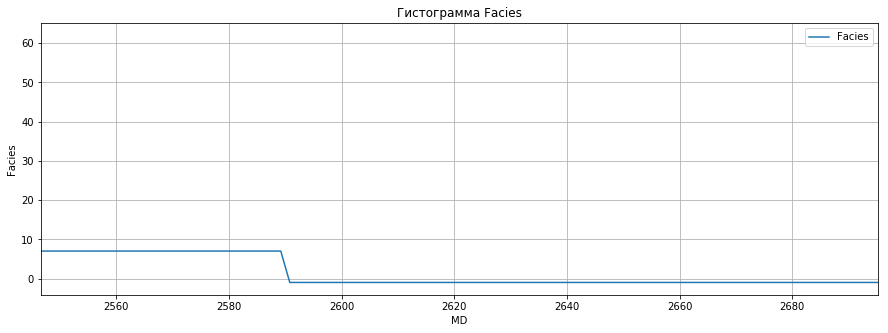

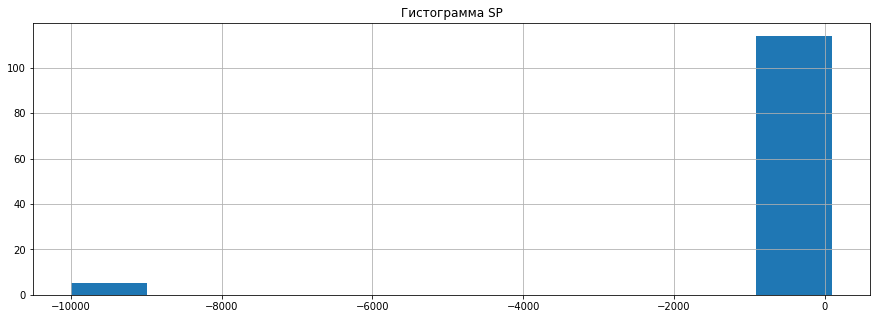

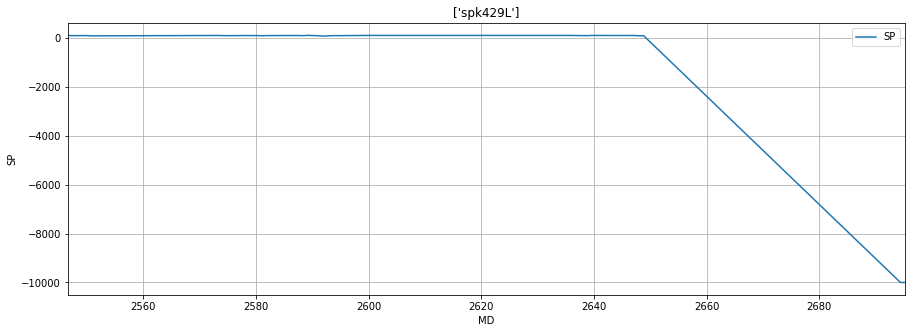

['Скважина - spk432R']
Статистика по всем значениям


MD         BK     Facies         GR   LIT       NKTB  \
count    32.000000  32.000000  32.000000  32.000000  32.0  32.000000   
mean   2639.550000   6.904750   5.000000   9.940281   4.0   4.565813   
std      24.640957   2.186273   3.519531   1.291304   0.0   0.286957   
min    2618.400000   4.542000  -1.000000   8.498000   4.0   3.810950   
25%    2623.300000   5.519750   5.000000   9.012000   4.0   4.427951   
50%    2630.100000   5.965500   7.000000   9.769500   4.0   4.593153   
75%    2643.550000   7.625000   7.000000  10.321500   4.0   4.764933   
max    2683.000000  11.804000   7.000000  14.940000   4.0   5.064987   

               SP  
count   32.000000  
mean   163.043072  
std     10.093007  
min    145.466800  
25%    155.203325  
50%    164.263250  
75%    171.811350  
max    184.422300

Статистика по известным значениям Facies


MD         BK  Facies         GR   LIT       NKTB          SP
count    24.000000  24.000000    24.0  24.000000  24.0  24.000000   24.000000
mean   2625.800000   5.724292     7.0  10.144292   4.0   4.596417  159.683479
std       5.228683   0.662376     0.0   1.389153   0.0   0.245774    9.434088
min    2618.400000   4.542000     7.0   8.548000   4.0   4.076468  145.466800
25%    2620.350000   5.344000     7.0   9.370250   4.0   4.462188  152.312525
50%    2624.900000   5.732000     7.0  10.084500   4.0   4.593153  159.211700
75%    2630.600000   6.043000     7.0  10.372000   4.0   4.764933  165.013350
max    2632.200000   6.978000     7.0  14.940000   4.0   5.064987  184.422300

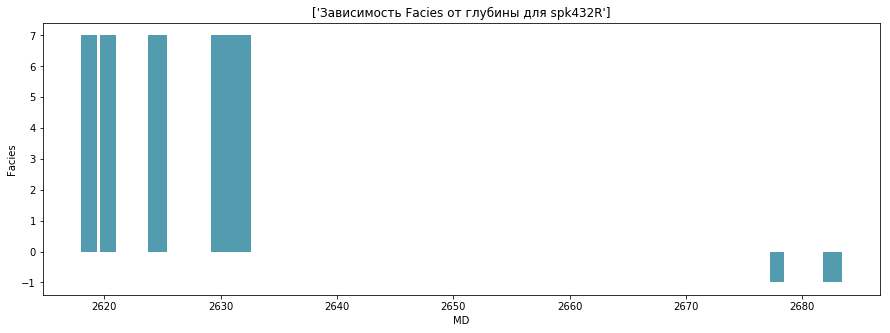

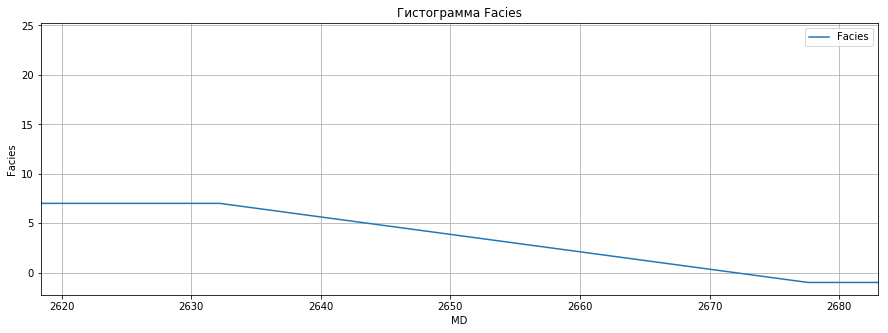

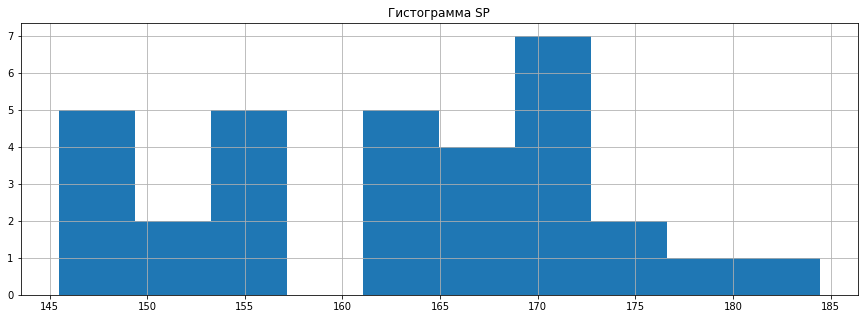

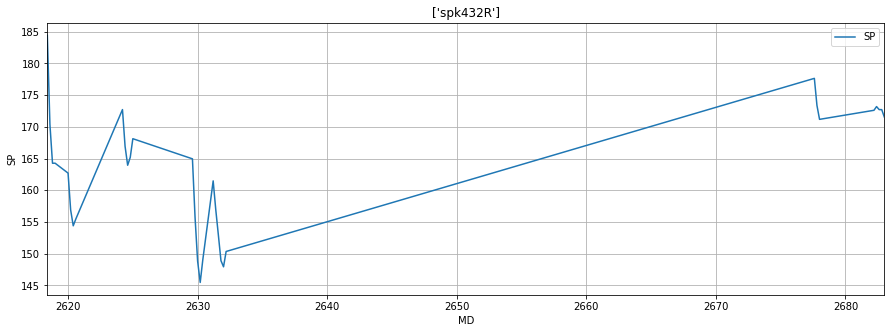

['Скважина - spk967']
Статистика по всем значениям


MD   BK    Facies         GR   LIT       NKTB          SP
count    24.000000  0.0  24.00000  24.000000  24.0  24.000000   24.000000
mean   2932.650000  NaN   2.50000   8.886250   4.0   4.118025  109.749560
std       9.767248  NaN   2.55377   0.582639   0.0   0.220787    5.872991
min    2922.600000  NaN   0.00000   7.860000   4.0   3.732640   97.675080
25%    2925.150000  NaN   0.00000   8.440000   4.0   3.903070  107.291675
50%    2928.500000  NaN   2.50000   8.920000   4.0   4.176930  109.716350
75%    2946.450000  NaN   5.00000   9.407500   4.0   4.289087  114.239650
max    2947.600000  NaN   5.00000   9.790000   4.0   4.475000  116.862400

Статистика по известным значениям Facies


MD   BK    Facies         GR   LIT       NKTB          SP
count    24.000000  0.0  24.00000  24.000000  24.0  24.000000   24.000000
mean   2932.650000  NaN   2.50000   8.886250   4.0   4.118025  109.749560
std       9.767248  NaN   2.55377   0.582639   0.0   0.220787    5.872991
min    2922.600000  NaN   0.00000   7.860000   4.0   3.732640   97.675080
25%    2925.150000  NaN   0.00000   8.440000   4.0   3.903070  107.291675
50%    2928.500000  NaN   2.50000   8.920000   4.0   4.176930  109.716350
75%    2946.450000  NaN   5.00000   9.407500   4.0   4.289087  114.239650
max    2947.600000  NaN   5.00000   9.790000   4.0   4.475000  116.862400

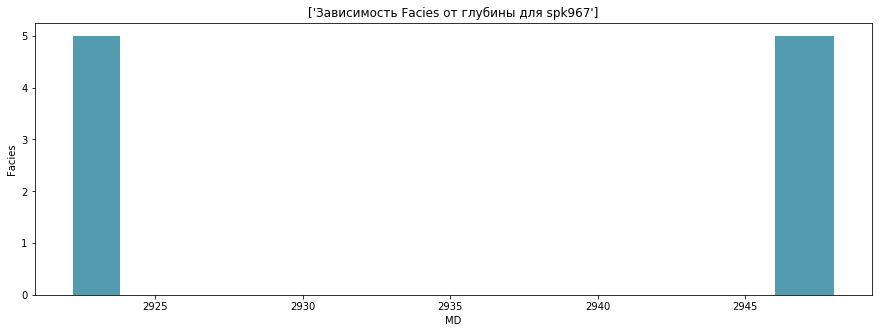

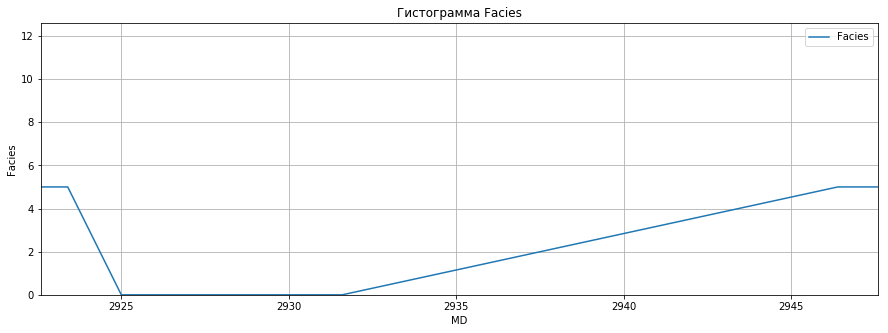

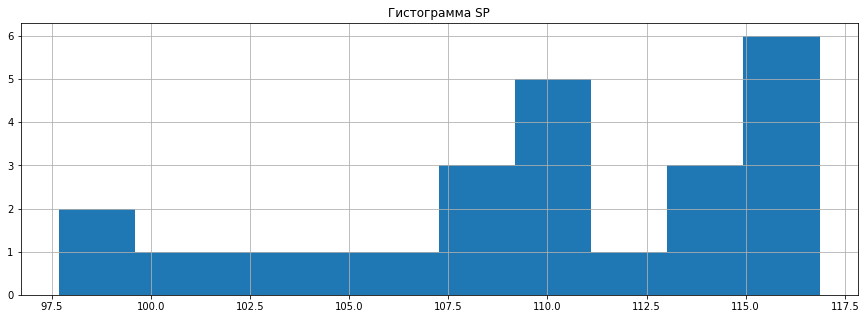

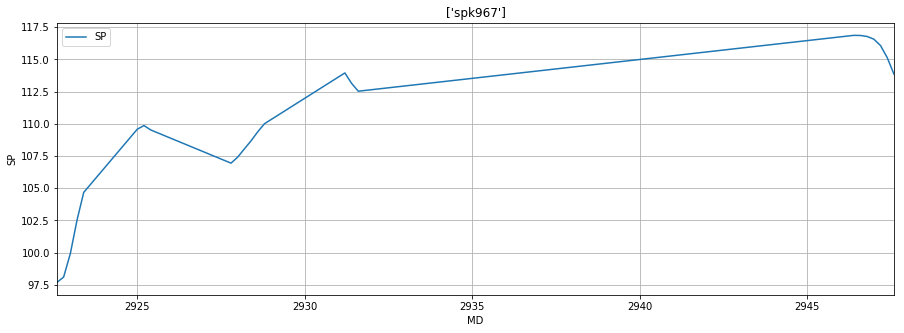

In [228]:
info_print(wells, 'SP')

In [12]:
wells[7]

wellName      MD    BK  Facies    GR  LIT      NKTB        SP
66490  spk409R  2548.0   9.0       8  5.24    4  3.882000  83.29516
66491  spk409R  2548.2   8.3       8  4.96    4  3.993131  83.59515
66492  spk409R  2548.4   7.9       8  4.68    4  4.095002  84.19516
66493  spk409R  2548.6  10.1       8  4.56    4  4.132046  83.19516
66494  spk409R  2548.8  10.4       8  4.96    4  4.206134  81.49516
66495  spk409R  2549.0   8.3       8  5.36    4  4.335787  80.89516
66500  spk409R  2550.0  11.2       8  4.76    4  4.132046  72.59515
66501  spk409R  2550.2  10.4       8  4.64    4  4.085742  70.89516
66502  spk409R  2550.4  10.1       8  5.08    4  4.011653  71.19516
66503  spk409R  2550.6  10.1       8  5.56    4  4.104263  72.49516
66504  spk409R  2550.8   9.7       8  6.04    4  4.206134  75.09515
66505  spk409R  2551.0  10.4       8  6.48    4  4.326526  78.19516
66506  spk409R  2551.2   7.9       8  6.92    4  4.437657  81.49516
66569  spk409R  2563.8   7.9       1  4.24    4  3.733825  86.09515
66570  spk409R  2564.0   8.6       1  3.60    4  3.789390  74.49516
66571  spk409R  2564.2   8.3       1  3.32    4  3.826434  65.89516
66572  spk409R  2564.4   7.9       1  3.00    4  3.872739  59.29516
66573  spk409R  2564.6   7.9       1  2.68    4  3.844956  54.09515
66574  spk409R  2564.8   7.6       1  2.56    4  4.326526  50.69516
66575  spk409R  2565.0   7.9       1  3.04    4  4.502484  49.39516
66576  spk409R  2565.2   7.9       1  3.56    4  4.474701  49.69516
66577  spk409R  2565.4   7.9       1  4.08    4  4.530267  51.79516
66578  spk409R  2565.6   8.3       1  4.12    4  4.585834  55.29516
66579  spk409R  2565.8   8.3       1  4.00    4  4.641399  60.19516
66580  spk409R  2566.0   8.3       1  4.48    4  4.511746  65.49516
66581  spk409R  2566.2   7.6       1  5.12    4  4.483963  71.89516
66854  spk409R  2620.8   7.9      -1  2.64    4  2.974426  81.99516
66855  spk409R  2621.0  10.1      -1  2.52    4  2.955904  75.79516
66856  spk409R  2621.2   8.6      -1  2.96    4  2.900339  72.69516
66857  spk409R  2621.4   8.3      -1  3.60    4  3.363386  72.59515
66858  spk409R  2621.6   7.9      -1  4.20    4  3.817173  75.79516
66859  spk409R  2621.8   7.2      -1  5.04    4  4.270960  81.49516

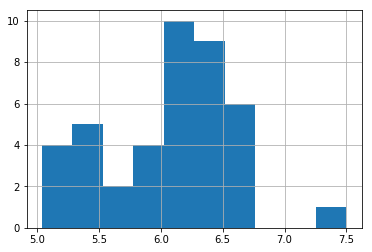

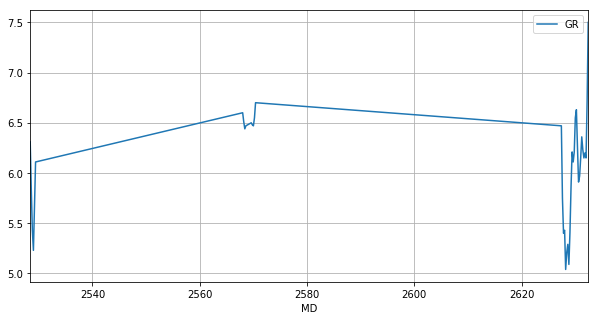

In [53]:
wells[4]['GR'].hist()
wells[4].plot(x='MD', y='GR', figsize=(10,5), grid=True)

#1baseline

In [5]:
def get_for_learn_clean_df(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["BK"] >= -999]
    feature = feature[feature["SP"] >= -999]
    return feature

for_ml = get_for_learn_clean_df(pd.read_csv('DATATRAIN18.csv', sep=';'))
display(for_ml.describe())
display(for_ml)

MD           BK      Facies           GR          LIT  \
count  2954.000000  2954.000000  2954.00000  2954.000000  2954.000000   
mean   2606.556364    10.946255     5.26608  -617.385604  -126.428910   
std     127.306556    11.162536     2.38241  2425.357626  1127.203192   
min    2507.600000     3.414000     0.00000 -9999.000000 -9999.000000   
25%    2547.600000     6.800000     5.00000     6.810000     1.000000   
50%    2568.200000     8.600000     5.00000     8.766500     1.000000   
75%    2595.600000    11.700000     7.00000    10.902250     4.000000   
max    3086.200000   231.100000    12.00000    18.340000     5.000000   

              NKTB           SP  
count  2954.000000  2954.000000  
mean   -622.073894   112.325442  
std    2424.144060    32.675092  
min   -9999.000000    49.395160  
25%       3.760663    93.534067  
50%       4.237521   108.352350  
75%       4.764340   124.523150  
max       8.589926   207.469100

wellName      MD      BK  Facies      GR  LIT      NKTB        SP
5044    spk1521  3019.8   8.040       8  12.410    5  4.431441  103.8600
5045    spk1521  3020.0   7.940       8  11.610    5  4.680739  103.7900
5046    spk1521  3020.2   9.900       8  11.460    5  4.794586  103.5300
5047    spk1521  3020.4  13.320       8  11.200    5  4.816397  104.6900
5048    spk1521  3020.6  14.990       8  11.380    5  4.809134  106.9300
5049    spk1521  3020.8  17.660       8  12.050    5  4.827276  107.6500
5050    spk1521  3021.0  15.780       8  12.880    1  4.702928  109.1200
5051    spk1521  3021.2  10.720       8  14.640    1  4.454518  110.9100
5052    spk1521  3021.4   8.010       8  16.860    1  4.171620  111.7100
5053    spk1521  3021.6   9.350       8  17.110    1  4.159534  108.6500
5054    spk1521  3021.8   9.820       8  15.290    1  4.392788  105.5000
5055    spk1521  3022.0   9.100       8  13.680    1  4.492788  103.9600
5056    spk1521  3022.2   9.610       8  13.100    1  4.545977  101.8300
5057    spk1521  3022.4  11.600       8  12.050    4  4.598722  101.2800
5058    spk1521  3022.6  12.570       8  10.520    4  4.654756  100.8000
5059    spk1521  3022.8  13.280       8   9.800    4  4.750749   99.7600
5060    spk1521  3023.0  14.150       8   9.450    4  4.830898   99.7500
5061    spk1521  3023.2  12.930       8   9.340    4  4.761736   99.7900
5062    spk1521  3023.4  11.980       8   9.360    4  4.848981  100.3300
5063    spk1521  3023.6  10.840       8   9.510    4  4.945802  101.3400
5064    spk1521  3023.8   9.270       8   9.860    4  4.938677  103.1400
5065    spk1521  3024.0   9.530       8  10.050    4  4.952920  103.3000
5066    spk1521  3024.2  10.600       8   9.920    4  4.885002  103.0600
5067    spk1521  3024.4  12.060       8   9.660    4  4.834518  104.9400
5068    spk1521  3024.6  12.560       8   9.570    4  4.725043  106.6800
5069    spk1521  3024.8  20.060       8   9.810    4  4.557316  108.1000
5070    spk1521  3025.0  14.120       8  10.460    4  4.385028  108.8100
5071    spk1521  3025.2   8.860       5  11.380    1  4.187695  110.4000
5072    spk1521  3025.4   7.060       5  12.610    1  3.941676  113.0200
5073    spk1521  3025.6   9.410       5  13.610    1  3.648751  115.2400
...         ...     ...     ...     ...     ...  ...       ...       ...
124790  spk432R  2628.6   5.283       7  10.071    2  4.341987  167.0245
124791  spk432R  2628.8   4.637       7  11.358    2  4.386240  167.5197
124792  spk432R  2629.0   4.512       7  11.900    1  4.473550  169.2248
124793  spk432R  2629.2   4.417       7  12.967    1  4.124907  170.3850
124794  spk432R  2629.4   4.653       7  15.165    1  4.597937  170.7572
124795  spk432R  2629.6   5.797       7  14.940    4  4.704982  164.9543
124796  spk432R  2629.8   6.978       7  12.808    4  4.801860  155.7985
124797  spk432R  2630.0   6.774       7  10.800    4  4.727706  148.8216
124798  spk432R  2630.2   5.999       7   9.724    4  4.704982  145.4668
124799  spk432R  2630.4   6.757       7   8.709    4  4.233746  149.0440
124800  spk432R  2630.6   8.227       7   7.761    5  4.893954  155.1481
124801  spk432R  2630.8   9.271       7   7.378    5  5.353230  161.0703
124802  spk432R  2631.0   8.311       7   8.456    5  5.278478  163.4244
124803  spk432R  2631.2   6.595       7   9.536    4  4.754019  161.4796
124804  spk432R  2631.4   5.384       7   9.445    4  4.467570  156.9438
124805  spk432R  2631.6   5.895       7   9.815    4  4.373682  152.9669
124806  spk432R  2631.8   5.853       7  10.284    4  4.339595  148.9061
124807  spk432R  2632.0   5.611       7  10.326    4  4.612289  147.9332
124808  spk432R  2632.2   4.840       7  10.198    4  4.486108  150.3494
124809  spk432R  2632.4   4.792       7  10.202    1  4.406572  155.5576
124810  spk432R  2632.6   4.393       7  10.450    1  4.037598  162.3457
124811  spk432R  2632.8   4.716       7  11.928    1  4.433483  172.1509
124812  spk432R  2633.0   5.128       7  13.056    1  4.317468  1

In [9]:
def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    return feature


def get_for_learn_target_class(for_all_feature_df):
    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']#.apply(lambda x: float(x))
    return target_class

features = get_for_learn_featres(for_ml)
target_facies = get_for_learn_target_class(for_ml)
display(features)


BK      GR      NKTB        SP
5044     8.040  12.410  4.431441  103.8600
5045     7.940  11.610  4.680739  103.7900
5046     9.900  11.460  4.794586  103.5300
5047    13.320  11.200  4.816397  104.6900
5048    14.990  11.380  4.809134  106.9300
5049    17.660  12.050  4.827276  107.6500
5050    15.780  12.880  4.702928  109.1200
5051    10.720  14.640  4.454518  110.9100
5052     8.010  16.860  4.171620  111.7100
5053     9.350  17.110  4.159534  108.6500
5054     9.820  15.290  4.392788  105.5000
5055     9.100  13.680  4.492788  103.9600
5056     9.610  13.100  4.545977  101.8300
5057    11.600  12.050  4.598722  101.2800
5058    12.570  10.520  4.654756  100.8000
5059    13.280   9.800  4.750749   99.7600
5060    14.150   9.450  4.830898   99.7500
5061    12.930   9.340  4.761736   99.7900
5062    11.980   9.360  4.848981  100.3300
5063    10.840   9.510  4.945802  101.3400
5064     9.270   9.860  4.938677  103.1400
5065     9.530  10.050  4.952920  103.3000
5066    10.600   9.920  4.885002  103.0600
5067    12.060   9.660  4.834518  104.9400
5068    12.560   9.570  4.725043  106.6800
5069    20.060   9.810  4.557316  108.1000
5070    14.120  10.460  4.385028  108.8100
5071     8.860  11.380  4.187695  110.4000
5072     7.060  12.610  3.941676  113.0200
5073     9.410  13.610  3.648751  115.2400
...        ...     ...       ...       ...
124790   5.283  10.071  4.341987  167.0245
124791   4.637  11.358  4.386240  167.5197
124792   4.512  11.900  4.473550  169.2248
124793   4.417  12.967  4.124907  170.3850
124794   4.653  15.165  4.597937  170.7572
124795   5.797  14.940  4.704982  164.9543
124796   6.978  12.808  4.801860  155.7985
124797   6.774  10.800  4.727706  148.8216
124798   5.999   9.724  4.704982  145.4668
124799   6.757   8.709  4.233746  149.0440
124800   8.227   7.761  4.893954  155.1481
124801   9.271   7.378  5.353230  161.0703
124802   8.311   8.456  5.278478  163.4244
124803   6.595   9.536  4.754019  161.4796
124804   5.384   9.445  4.467570  156.9438
124805   5.895   9.815  4.373682  152.9669
124806   5.853  10.284  4.339595  148.9061
124807   5.611  10.326  4.612289  147.9332
124808   4.840  10.198  4.486108  150.3494
124809   4.792  10.202  4.406572  155.5576
124810   4.393  10.450  4.037598  162.3457
124811   4.716  11.928  4.433483  172.1509
124812   5.128  13.056  4.317468  174.7020
124813   5.069  13.634  4.919071  178.6012
124814   5.004  12.646  3.819322  185.3154
124815   5.914  11.686  3.921583  187.6145
124816   6.864  12.223  4.418533  187.8437
124817   6.950  13.268  4.754019  192.4768
124818   6.773  13.701  4.581193  192.6070
124819   7.369  13.306  4.483716  191.7632

[2954 rows x 4 columns]

In [26]:
def p(target, labels):
    print('RMSE ошибка равна',mean_squared_error(target, labels))
    print(classification_report(target, labels))
def p_cross_val(model, train, labels):
    print('cross_val_predict')
    predicted = cross_val_predict(model, train, labels, cv=10)
    print(classification_report(labels, predicted))
    
def logistic_regression(train, labels):
    print('logistic_regression')
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(random_state=18)
    rfe = RFE(model, 4)
    rfe = rfe.fit(X_train, y_train)
    p(y_test, rfe.predict(X_test))
    p_cross_val(rfe, train, labels)
    return rfe

logistic_regression(features, target_facies)  

logistic_regression
RMSE ошибка равна 5.66065388951522
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       1.00      0.11      0.20        27
           3       0.00      0.00      0.00        24
           5       0.63      0.93      0.75       522
           7       0.31      0.19      0.23       178
           8       0.00      0.00      0.00        38
          12       0.00      0.00      0.00        28

   micro avg       0.59      0.59      0.59       887
   macro avg       0.28      0.18      0.17       887
weighted avg       0.46      0.59      0.49       887

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\me

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       233
           1       0.82      0.10      0.19        86
           3       0.00      0.00      0.00        85
           5       0.57      0.88      0.70      1674
           7       0.18      0.10      0.13       635
           8       0.00      0.00      0.00       123
          12       0.00      0.00      0.00       118

   micro avg       0.53      0.53      0.53      2954
   macro avg       0.22      0.16      0.14      2954
weighted avg       0.39      0.53      0.43      2954



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=18, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
  n_features_to_select=4, step=1, verbose=0)

In [27]:
def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    ridge_model = RidgeClassifier(random_state = 18)
    ridge_model.fit(train, labels)
    p(y_test, ridge_model.predict(X_test))
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(features, target_facies)

RMSE ошибка равна 5.274111675126903
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.00      0.00      0.00        17
           3       0.00      0.00      0.00        16
           5       0.63      0.97      0.76       354
           7       0.34      0.14      0.20       115
           8       0.00      0.00      0.00        29
          12       0.00      0.00      0.00        16

   micro avg       0.61      0.61      0.61       591
   macro avg       0.14      0.16      0.14       591
weighted avg       0.44      0.61      0.50       591

cross_val_predict
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       233
           1       0.00      0.00      0.00        86
           3       0.00      0.00      0.00        85
           5       0.57      0.91      0.70      1674
           7       0.14      0.06      0.09       635
           8       0.00 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=18, solver='auto',
        tol=0.001)

In [28]:
def get_KNeighborsClassifier(x ,target):
    X_train, X_test, y_train, y_test = train_test_split(x, target, train_size=0.7)
    for k in range(1,15):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train, y_train)
        print(" n_neighbors ")
        print(k)
        print(classification_report(y_test, classifier.predict(X_test)))
        predicted = cross_val_predict(classifier, x, target, cv=10)
        print(" cross_val_predict " + str(k) + ' neighbors ')
        print(classification_report(target, predicted))

get_KNeighborsClassifier(features, target_facies)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


 n_neighbors 
1
              precision    recall  f1-score   support

           0       0.56      0.70      0.62        40
           1       0.73      0.55      0.63        20
           3       0.73      0.55      0.63        20
           5       0.91      0.90      0.91       335
           7       0.83      0.84      0.83       131
           8       0.43      0.43      0.43        21
          12       0.58      0.58      0.58        24

   micro avg       0.82      0.82      0.82       591
   macro avg       0.68      0.65      0.66       591
weighted avg       0.83      0.82      0.82       591

 cross_val_predict 1 neighbors 
              precision    recall  f1-score   support

           0       0.32      0.43      0.37       233
           1       0.47      0.53      0.50        86
           3       0.43      0.52      0.47        85
           5       0.79      0.72      0.75      1674
           7       0.54      0.50      0.52       635
           8       0.25      0

 cross_val_predict 8 neighbors 
              precision    recall  f1-score   support

           0       0.30      0.45      0.36       233
           1       0.85      0.48      0.61        86
           3       0.37      0.47      0.41        85
           5       0.80      0.78      0.79      1674
           7       0.52      0.51      0.52       635
           8       0.20      0.13      0.16       123
          12       0.10      0.08      0.09       118

   micro avg       0.62      0.62      0.62      2954
   macro avg       0.45      0.41      0.42      2954
weighted avg       0.63      0.62      0.63      2954

 n_neighbors 
9
              precision    recall  f1-score   support

           0       0.50      0.62      0.56        40
           1       0.90      0.45      0.60        20
           3       0.60      0.45      0.51        20
           5       0.87      0.93      0.89       335
           7       0.74      0.78      0.76       131
           8       0.46      0

In [29]:
def get_gradientBoostingClassifier(train, labels):
    from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
    from sklearn.ensemble import GradientBoostingClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    reg = GradientBoostingClassifier(random_state = 18)
    reg.fit(X_train, y_train)
    p(y_test, reg.predict(X_test))
    p_cross_val(reg, train, labels)
    return reg

    
get_gradientBoostingClassifier(features, target_facies) 

RMSE ошибка равна 4.126903553299492
              precision    recall  f1-score   support

           0       0.64      0.61      0.63        44
           1       0.67      0.35      0.46        17
           3       0.56      0.62      0.59        16
           5       0.89      0.93      0.91       354
           7       0.77      0.77      0.77       115
           8       0.69      0.38      0.49        29
          12       0.45      0.56      0.50        16

   micro avg       0.82      0.82      0.82       591
   macro avg       0.67      0.61      0.62       591
weighted avg       0.81      0.82      0.81       591

cross_val_predict
              precision    recall  f1-score   support

           0       0.41      0.35      0.38       233
           1       0.45      0.41      0.43        86
           3       0.38      0.47      0.42        85
           5       0.78      0.81      0.79      1674
           7       0.51      0.52      0.52       635
           8       0.31 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=18,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [30]:
def get_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    
    reg = RandomForestClassifier(random_state = 18)
    params = {}
    cb_model = GridSearchCV(reg, params, cv = 5)
    cb_model.fit(X_train, y_train)
    
    pred_class_all = cb_model.predict(X_test)
    preds_proba_all = cb_model.predict_proba(X_test)
    
    p(y_test, cb_model.best_estimator_.predict(X_test).round())
    p_cross_val(cb_model.best_estimator_, train, labels)
    return cb_model.best_estimator_

get_randomForestRegressor(features, target_facies) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

RMSE ошибка равна 3.55160744500846
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        44
           1       0.81      0.76      0.79        17
           3       0.62      0.62      0.62        16
           5       0.92      0.95      0.93       354
           7       0.85      0.84      0.85       115
           8       0.89      0.55      0.68        29
          12       0.50      0.44      0.47        16

   micro avg       0.86      0.86      0.86       591
   macro avg       0.75      0.70      0.72       591
weighted avg       0.86      0.86      0.86       591

cross_val_predict
              precision    recall  f1-score   support

           0       0.35      0.45      0.39       233
           1       0.54      0.56      0.55        86
           3       0.42      0.45      0.43        85
           5       0.78      0.79      0.79      1674
           7       0.54      0.49      0.51       635
           8       0.34  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=18, verbose=0, warm_start=False)

In [31]:
def get_catBoost(train, labels):
    from catboost import CatBoostClassifier, Pool
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    train_data = catboost_pool = Pool(X_train, 
                                 y_train)
    test_data = catboost_pool = Pool(X_test, 
                                     y_test)

    model = CatBoostClassifier(iterations=100,
                               loss_function='MultiClass',
                           logging_level='Silent')
    #train the model
    model.fit(train_data)
    preds_class = model.predict(test_data)
    preds_proba = model.predict_proba(test_data)
    p(y_test, preds_class)
    p_cross_val(model, train, labels)
    return model
    
get_catBoost(features, target_facies)

RMSE ошибка равна 4.084602368866328
              precision    recall  f1-score   support

           0       0.72      0.41      0.52        44
           1       0.92      0.65      0.76        17
           3       1.00      0.31      0.48        16
           5       0.84      0.97      0.90       354
           7       0.66      0.79      0.72       115
           8       0.75      0.10      0.18        29
          12       0.00      0.00      0.00        16

   micro avg       0.80      0.80      0.80       591
   macro avg       0.70      0.46      0.51       591
weighted avg       0.78      0.80      0.76       591

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.44      0.30      0.35       233
           1       0.62      0.34      0.44        86
           3       0.76      0.15      0.25        85
           5       0.75      0.88      0.81      1674
           7       0.48      0.54      0.51       635
           8       0.28      0.06      0.09       123
          12       0.00      0.00      0.00       118

   micro avg       0.65      0.65      0.65      2954
   macro avg       0.47      0.32      0.35      2954
weighted avg       0.61      0.65      0.62      2954



In [104]:
def get_clean_df(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    #feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["LIT"] == 4]
    #feature = feature[feature["Facies"] != -9999]
    return feature

filter_base_df_prod = get_clean_df(base_statistic_df)


wall_names = base_statistic_df['datasetName'].unique()
print(wall_names)

filter_base_df_prod = filter_base_df_prod[filter_base_df_prod['wellName'] == 'spk432R']
display(filter_base_df_prod.describe())
display(filter_base_df_prod[filter_base_df_prod['Facies'] == -9999])
#['spk1521' 'spk1527' 'spk1769' 'spk400' 'spk403' 'spk405R' 'spk409R'
# 'spk420R' 'spk424R' 'spk426R' 'spk427R' 'spk428R' 'spk429L' 'spk432R'
# 'spk967']

['TrainLogs']


MD         BK       Facies         GR   LIT       NKTB  \
count    32.000000  32.000000    32.000000  32.000000  32.0  32.000000   
mean   2639.550000   6.904750 -2494.500000   9.940281   4.0   4.565813   
std      24.640957   2.186273  4402.053099   1.291304   0.0   0.286957   
min    2618.400000   4.542000 -9999.000000   8.498000   4.0   3.810950   
25%    2623.300000   5.519750 -2494.500000   9.012000   4.0   4.427951   
50%    2630.100000   5.965500     7.000000   9.769500   4.0   4.593153   
75%    2643.550000   7.625000     7.000000  10.321500   4.0   4.764933   
max    2683.000000  11.804000     7.000000  14.940000   4.0   5.064987   

               SP  
count   32.000000  
mean   163.043072  
std     10.093007  
min    145.466800  
25%    155.203325  
50%    164.263250  
75%    171.811350  
max    184.422300

wellName      MD      BK  Facies      GR  LIT      NKTB        SP
125035  spk432R  2677.6   9.566   -9999   9.577    4  4.158396  177.6411
125036  spk432R  2677.8   9.608   -9999   9.075    4  3.810950  173.3771
125037  spk432R  2678.0  10.087   -9999   8.933    4  4.121918  171.1791
125058  spk432R  2682.2   9.935   -9999   8.960    4  4.749235  172.6071
125059  spk432R  2682.4  10.619   -9999   8.498    4  4.865848  173.1941
125060  spk432R  2682.6  11.037   -9999   9.022    4  4.549498  172.7191
125061  spk432R  2682.8  10.913   -9999   9.895    4  4.801860  172.7111
125062  spk432R  2683.0  11.804   -9999  10.666    4  4.734284  171.5461

In [105]:
def get_validate_well(base_df):
    return base_df[base_df['Facies'] == -9999]

validate_well = get_validate_well(filter_base_df_prod)
display(validate_well.describe())
features = get_for_learn_featres(validate_well)

MD         BK  Facies         GR  LIT      NKTB          SP
count     8.000000   8.000000     8.0   8.000000  8.0  8.000000    8.000000
mean   2680.800000  10.446125 -9999.0   9.328250  4.0  4.473999  173.121850
std       2.497999   0.784502     0.0   0.687826  0.0  0.391598    1.976546
min    2677.600000   9.566000 -9999.0   8.498000  4.0  3.810950  171.179100
25%    2677.950000   9.853250 -9999.0   8.953250  4.0  4.149277  172.341850
50%    2682.300000  10.353000 -9999.0   9.048500  4.0  4.641891  172.715100
75%    2682.650000  10.944000 -9999.0   9.656500  4.0  4.762391  173.239850
max    2683.000000  11.804000 -9999.0  10.666000  4.0  4.865848  177.641100

In [106]:
features

BK      GR      NKTB        SP
125035   9.566   9.577  4.158396  177.6411
125036   9.608   9.075  3.810950  173.3771
125037  10.087   8.933  4.121918  171.1791
125058   9.935   8.960  4.749235  172.6071
125059  10.619   8.498  4.865848  173.1941
125060  11.037   9.022  4.549498  172.7191
125061  10.913   9.895  4.801860  172.7111
125062  11.804  10.666  4.734284  171.5461

In [107]:
result = simple_model.predict(features)
print(result)
print(catboost_model.predict(features))
result_df = pd.DataFrame(columns=['predict'])
#result_df['predict'] = list(simple_model.predict(features))

[7 7 7 7 7 7 7 7]
[[5.]
 [5.]
 [5.]
 [7.]
 [7.]
 [7.]
 [7.]
 [5.]]


In [108]:
result_df

Empty DataFrame
Columns: [predict]
Index: []

In [109]:
validate_well['predict_gb'] = simple_model.predict(features)
validate_well['predict_cb'] = catboost_model.predict(features)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [110]:
validate_well

wellName      MD      BK  Facies      GR  LIT      NKTB        SP  \
125035  spk432R  2677.6   9.566   -9999   9.577    4  4.158396  177.6411   
125036  spk432R  2677.8   9.608   -9999   9.075    4  3.810950  173.3771   
125037  spk432R  2678.0  10.087   -9999   8.933    4  4.121918  171.1791   
125058  spk432R  2682.2   9.935   -9999   8.960    4  4.749235  172.6071   
125059  spk432R  2682.4  10.619   -9999   8.498    4  4.865848  173.1941   
125060  spk432R  2682.6  11.037   -9999   9.022    4  4.549498  172.7191   
125061  spk432R  2682.8  10.913   -9999   9.895    4  4.801860  172.7111   
125062  spk432R  2683.0  11.804   -9999  10.666    4  4.734284  171.5461   

        predict_gb  predict_cb  
125035           7         5.0  
125036           7         5.0  
125037           7         5.0  
125058           7         7.0  
125059           7         7.0  
125060           7         7.0  
125061           7         7.0  
125062           7         5.0

In [112]:
validate_well[validate_well['predict_cb'] > 0].to_csv('spk432R_TrainLogs.csv', index=False)